
Larry Zeng, February 8, 2022
Phantom Generation

# CS 6480 LarryPhantomGeneration.ipynb

## Load the Shepp-Logan phantom and generate its sinogram (a.k.a. Radon transform, projections)
https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html

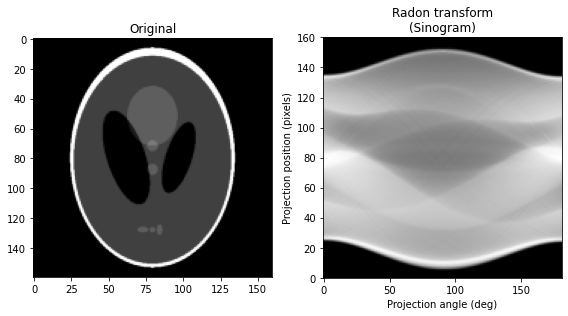

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()

## Ramp filter

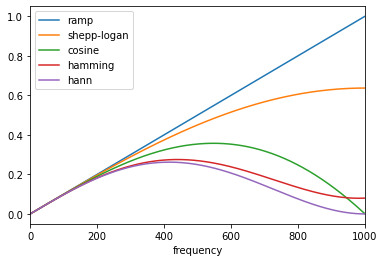

In [2]:
import matplotlib.pyplot as plt
from skimage.transform.radon_transform import _get_fourier_filter

filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

for ix, f in enumerate(filters):
    response = _get_fourier_filter(2000, f)
    plt.plot(response, label=f)

plt.xlim([0, 1000])
plt.xlabel('frequency')
plt.legend()
plt.show()

## Image reconstruction (iradon)

FBP rms reconstruction error: 0.0283


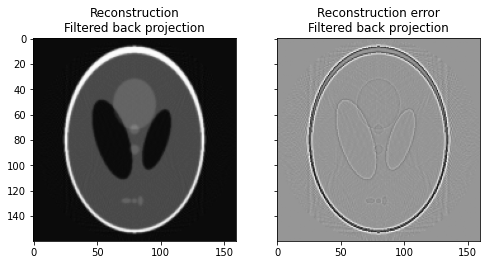

In [3]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

## Phantom generator
https://jenda.hrach.eu/f2/cat-py/phantom.py

In [4]:
## Copyright (C) 2010  Alex Opie  <lx_op@orcon.net.nz>
##
## This program is free software; you can redistribute it and/or modify it
## under the terms of the GNU General Public License as published by
## the Free Software Foundation; either version 3 of the License, or (at
## your option) any later version.
##
## This program is distributed in the hope that it will be useful, but
## WITHOUT ANY WARRANTY; without even the implied warranty of
## MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.	See the GNU
## General Public License for more details.
##
## You should have received a copy of the GNU General Public License
## along with this program; see the file COPYING.  If not, see
## <http://www.gnu.org/licenses/>.

import numpy as np

def phantom (n = 256, p_type = 'Modified Shepp-Logan', ellipses = None):
	"""
	 phantom (n = 256, p_type = 'Modified Shepp-Logan', ellipses = None)
	
	Create a Shepp-Logan or modified Shepp-Logan phantom.

	A phantom is a known object (either real or purely mathematical) 
	that is used for testing image reconstruction algorithms.  The 
	Shepp-Logan phantom is a popular mathematical model of a cranial
	slice, made up of a set of ellipses.  This allows rigorous 
	testing of computed tomography (CT) algorithms as it can be 
	analytically transformed with the radon transform (see the 
	function `radon').
	
	Inputs
	------
	n : The edge length of the square image to be produced.
	
	p_type : The type of phantom to produce. Either 
	  "Modified Shepp-Logan" or "Shepp-Logan".  This is overridden
	  if `ellipses' is also specified.
	
	ellipses : Custom set of ellipses to use.  These should be in 
	  the form
	  	[[I, a, b, x0, y0, phi],
	  	 [I, a, b, x0, y0, phi],
	  	 ...]
	  where each row defines an ellipse.
	  I : Additive intensity of the ellipse.
	  a : Length of the major axis.
	  b : Length of the minor axis.
	  x0 : Horizontal offset of the centre of the ellipse.
	  y0 : Vertical offset of the centre of the ellipse.
	  phi : Counterclockwise rotation of the ellipse in degrees,
	        measured as the angle between the horizontal axis and 
	        the ellipse major axis.
	  The image bounding box in the algorithm is [-1, -1], [1, 1], 
	  so the values of a, b, x0, y0 should all be specified with
	  respect to this box.
	
	Output
	------
	P : A phantom image.
	
	Usage example
	-------------
	  import matplotlib.pyplot as pl
	  P = phantom ()
	  pl.imshow (P)
	
	References
	----------
	Shepp, L. A.; Logan, B. F.; Reconstructing Interior Head Tissue 
	from X-Ray Transmissions, IEEE Transactions on Nuclear Science,
	Feb. 1974, p. 232.
	
	Toft, P.; "The Radon Transform - Theory and Implementation", 
	Ph.D. thesis, Department of Mathematical Modelling, Technical 
	University of Denmark, June 1996.
	
	"""
	
	if (ellipses is None):
		ellipses = _select_phantom (p_type)
	elif (np.size (ellipses, 1) != 6):
		raise AssertionError ("Wrong number of columns in user phantom")
	
	# Blank image
	p = np.zeros ((n, n))

	# Create the pixel grid
	ygrid, xgrid = np.mgrid[-1:1:(1j*n), -1:1:(1j*n)]

	for ellip in ellipses:
		I   = ellip [0]
		a2  = ellip [1]**2
		b2  = ellip [2]**2
		x0  = ellip [3]
		y0  = ellip [4]
		phi = ellip [5] * np.pi / 180  # Rotation angle in radians
		
		# Create the offset x and y values for the grid
		x = xgrid - x0
		y = ygrid - y0
		
		cos_p = np.cos (phi) 
		sin_p = np.sin (phi)
		
		# Find the pixels within the ellipse
		locs = (((x * cos_p + y * sin_p)**2) / a2 
              + ((y * cos_p - x * sin_p)**2) / b2) <= 1
		
		# Add the ellipse intensity to those pixels
		p [locs] += I

	return p


def _select_phantom (name):
	if (name.lower () == 'shepp-logan'):
		e = _shepp_logan ()
	elif (name.lower () == 'modified shepp-logan'):
		e = _mod_shepp_logan ()
	else:
		raise ValueError ("Unknown phantom type: %s" % name)
	
	return e


def _shepp_logan ():
	#  Standard head phantom, taken from Shepp & Logan
	return [[   2,   .69,   .92,    0,      0,   0],
	        [-.98, .6624, .8740,    0, -.0184,   0],
	        [-.02, .1100, .3100,  .22,      0, -18],
	        [-.02, .1600, .4100, -.22,      0,  18],
	        [ .01, .2100, .2500,    0,    .35,   0],
	        [ .01, .0460, .0460,    0,     .1,   0],
	        [ .02, .0460, .0460,    0,    -.1,   0],
	        [ .01, .0460, .0230, -.08,  -.605,   0],
	        [ .01, .0230, .0230,    0,  -.606,   0],
	        [ .01, .0230, .0460,  .06,  -.605,   0]]

def _mod_shepp_logan ():
	#  Modified version of Shepp & Logan's head phantom, 
	#  adjusted to improve contrast.  Taken from Toft.
	return [[   1,   .69,   .92,    0,      0,   0],
	        [-.80, .6624, .8740,    0, -.0184,   0],
	        [-.20, .1100, .3100,  .22,      0, -18],
	        [-.20, .1600, .4100, -.22,      0,  18],
	        [ .10, .2100, .2500,    0,    .35,   0],
	        [ .10, .0460, .0460,    0,     .1,   0],
	        [ .10, .0460, .0460,    0,    -.1,   0],
	        [ .10, .0460, .0230, -.08,  -.605,   0],
	        [ .10, .0230, .0230,    0,  -.606,   0],
	        [ .10, .0230, .0460,  .06,  -.605,   0]]

#def ?? ():
#	# Add any further phantoms of interest here
#	return np.array (
#	 [[ 0, 0, 0, 0, 0, 0],
#	  [ 0, 0, 0, 0, 0, 0]])



## Make your own phantom

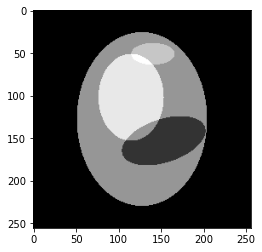

In [5]:
import matplotlib.pyplot as pl
# P = phantom ()
# pl.imshow (P)

E = [[   0.3,   .6,   .8,    0,      0,   0],
     [   0.2,   .3,   .4, -0.1,   -.2,   0],
     [   -.2,   .4,   .2,   .2,     .2, -18],
     [   .10,   .2,   .1,   .1,    -.6,   0]]
P = phantom (n = 256, p_type = 'ellipses', ellipses = E)
pl.imshow (P, cmap=plt.cm.Greys_r)




## Random phantom

In [6]:
import numpy as np
  
x=np.random.random(24)
print(x[5])

0.0730049495165297


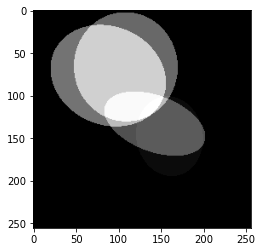

In [7]:
x=np.random.random(24)
E = [[   x[ 0]-0.0,   0.5*x[ 1]+0.2,   0.5*x[ 2]+0.2,    x[ 3]-0.5,      x[ 4]-0.5,   100*x[ 5]   ],
     [   x[ 6]-0.1,   0.4*x[ 7]+0.2,   0.4*x[ 8]+0.2,    x[ 9]-0.5,      x[10]-0.5,   100*x[11]   ],
     [   x[12]-0.2,   0.3*x[13]+0.2,   0.3*x[14]+0.2,    x[15]-0.5,      x[16]-0.5,   100*x[17]   ],
     [   x[18]-0.3,   0.2*x[19]+0.2,   0.2*x[20]+0.2,    x[21]-0.5,      x[22]-0.5,   100*x[23]  ]] 
P = phantom (n = 256, p_type = 'ellipses', ellipses = E)
P = np.maximum(0,P)
pl.imshow (P, cmap=plt.cm.Greys_r)

## Images with different resolutions

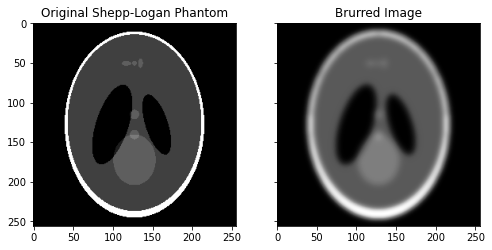

In [76]:
import matplotlib.pyplot as pl
import skimage.io
import skimage.filters
import sys



P = phantom ()
# pl.imshow (P, cmap=plt.cm.Greys_r)

sigma = 4
blurred = skimage.filters.gaussian(
    P, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
# skimage.io.imshow(blurred, cmap=plt.cm.Greys_r)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Original Shepp-Logan Phantom")
ax1.imshow(P, cmap=plt.cm.Greys_r)
ax2.set_title("Brurred Image")
ax2.imshow(blurred, cmap=plt.cm.Greys_r)
plt.show()

## Generating Shiftted Images

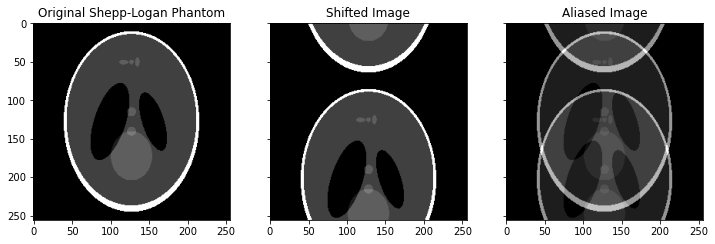

In [40]:
P = phantom ()

P_shifted = np.roll(P, shift=75, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Original Shepp-Logan Phantom")
ax1.imshow(P, cmap=plt.cm.Greys_r)
ax2.set_title("Shifted Image")
ax2.imshow(P_shifted, cmap=plt.cm.Greys_r)
ax3.set_title("Aliased Image")
ax3.imshow(P_shifted + P, cmap=plt.cm.Greys_r)
plt.show()

## Angular Aliasing due to sparse angular sampling

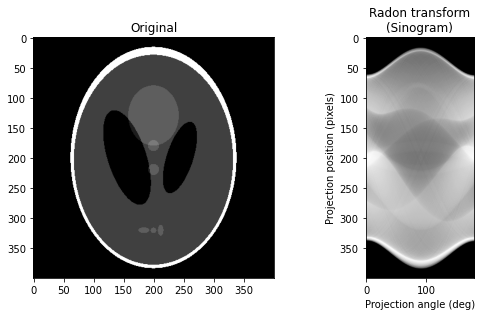

(400, 180)
(180,)
FBP rms reconstruction error: 0.228


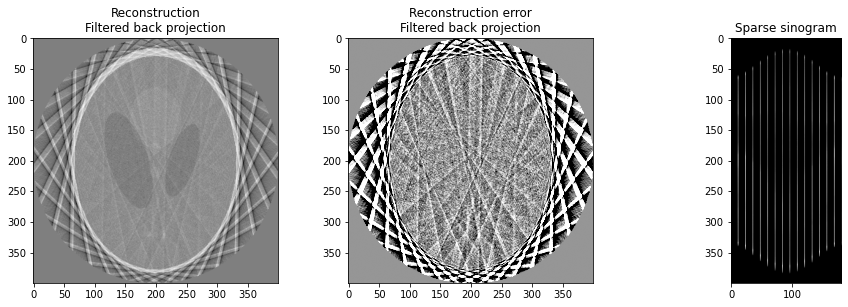

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
# image = rescale(image, scale=1, mode='reflect')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

# theta = np.linspace(0., 180., max(image.shape), endpoint=False)
theta = np.arange(0, 180)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)
#           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
#           aspect='auto')

fig.tight_layout()
plt.show()

print(sinogram.shape)
print(theta.shape)


sinogram[:,0:180:12] = 0
sinogram[:,1:180:12] = 0
sinogram[:,2:180:12] = 0
sinogram[:,3:180:12] = 0
sinogram[:,4:180:12] = 0
sinogram[:,5:180:12] = 0
sinogram[:,6:180:12] = 0
sinogram[:,7:180:12] = 0
sinogram[:,8:180:12] = 0
sinogram[:,9:180:12] = 0
sinogram[:,10:180:12] = 0

reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax10, ax20, ax30) = plt.subplots(1, 3, figsize=(16, 4.5))
#                              sharex=True, sharey=True)
ax10.set_title("Reconstruction\nFiltered back projection")
ax10.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax20.set_title("Reconstruction error\nFiltered back projection")
ax20.imshow(12*reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
ax30.set_title("Sparse sinogram")
ax30.imshow(sinogram, cmap=plt.cm.Greys_r)
plt.show()

## Deleting some views

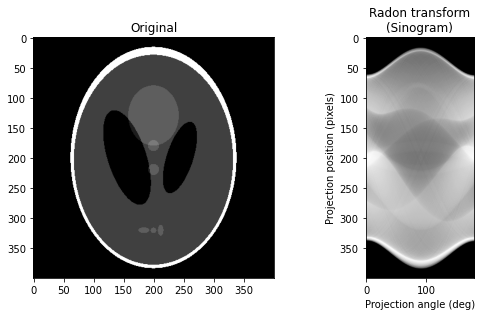

(400, 180)
(180,)
(15,)
(400, 15)
FBP rms reconstruction error: 0.233


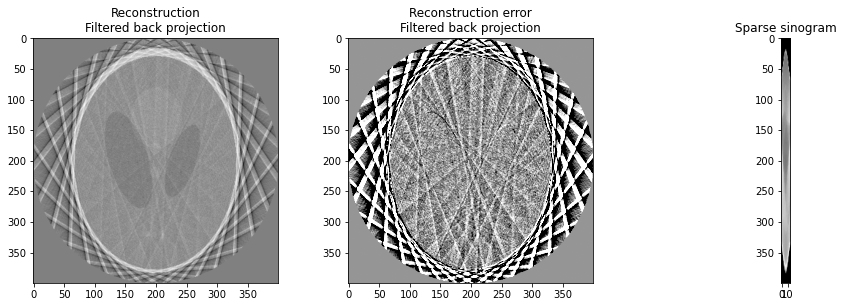

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
# image = rescale(image, scale=1, mode='reflect')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

# theta = np.linspace(0., 180., max(image.shape), endpoint=False)
theta = np.arange(0, 180)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)
#           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
#           aspect='auto')

fig.tight_layout()
plt.show()

print(sinogram.shape)
print(theta.shape)

sinogram1 = np.zeros([400, 15])

sinogram1 = np.delete(sinogram,[np.arange(0,180,12),
                               np.arange(1,180,12),
                               np.arange(2,180,12),
                               np.arange(3,180,12),
                               np.arange(4,180,12),
                               np.arange(5,180,12),
                               np.arange(6,180,12),
                               np.arange(7,180,12),
                               np.arange(8,180,12),
                               np.arange(9,180,12),
                               np.arange(10,180,12),], 1)

theta1=np.arange(10,180,12)
print(theta1.shape)
print(sinogram1.shape)

reconstruction_fbp = iradon(sinogram1, theta=theta1, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax10, ax20, ax30) = plt.subplots(1, 3, figsize=(16, 4.5))
#                              sharex=True, sharey=True)
ax10.set_title("Reconstruction\nFiltered back projection")
ax10.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax20.set_title("Reconstruction error\nFiltered back projection")
ax20.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
ax30.set_title("Sparse sinogram")
ax30.imshow(sinogram1, cmap=plt.cm.Greys_r)
plt.show()

## Add Noise in the Sinogram

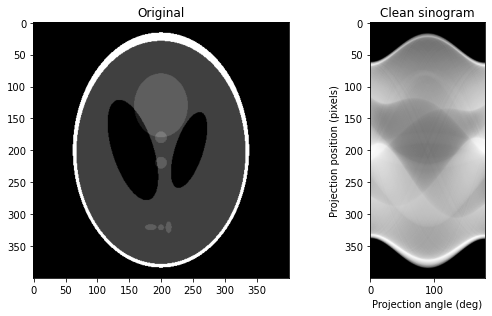

(400, 180)
(180,)
106236.78932477845


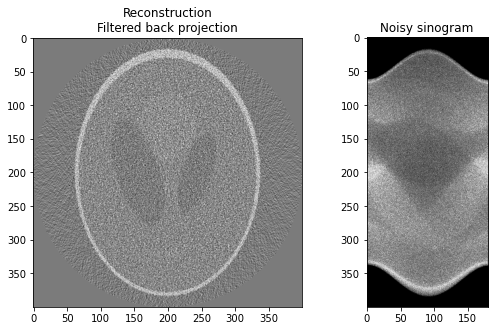

In [19]:
import matplotlib.pyplot as plt
from skimage.transform import iradon
from skimage.util import random_noise

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
# image = rescale(image, scale=1, mode='reflect')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

# theta = np.linspace(0., 180., max(image.shape), endpoint=False)
theta = np.arange(0, 180)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Clean sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)
#           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
#           aspect='auto')

fig.tight_layout()
plt.show()

print(sinogram.shape)
print(theta.shape)

pmax = np.max(sinogram)*1000
print(pmax)
sinogram1 = pmax*random_noise(sinogram/pmax, mode='poisson', seed=None, clip=True)


reconstruction_fbp = iradon(sinogram1, theta=theta, filter_name='ramp')

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(8, 4.5))
#                              sharex=True, sharey=True)
ax3.set_title("Reconstruction\nFiltered back projection")
ax3.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)

ax4.set_title("Noisy sinogram")
ax4.imshow(sinogram1, cmap=plt.cm.Greys_r)
fig.tight_layout()
plt.show()

## 2/20/2022 Larry (Revisite 3/28/2022)

## Denoising using simuated data

** Phantom Generator **

In [1]:
## Copyright (C) 2010  Alex Opie  <lx_op@orcon.net.nz>
##
## This program is free software; you can redistribute it and/or modify it
## under the terms of the GNU General Public License as published by
## the Free Software Foundation; either version 3 of the License, or (at
## your option) any later version.
##
## This program is distributed in the hope that it will be useful, but
## WITHOUT ANY WARRANTY; without even the implied warranty of
## MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.	See the GNU
## General Public License for more details.
##
## You should have received a copy of the GNU General Public License
## along with this program; see the file COPYING.  If not, see
## <http://www.gnu.org/licenses/>.

import numpy as np

def phantom (n = 64, p_type = 'Modified Shepp-Logan', ellipses = None):
	"""
	 phantom (n = 256, p_type = 'Modified Shepp-Logan', ellipses = None)
	
	Create a Shepp-Logan or modified Shepp-Logan phantom.

	A phantom is a known object (either real or purely mathematical) 
	that is used for testing image reconstruction algorithms.  The 
	Shepp-Logan phantom is a popular mathematical model of a cranial
	slice, made up of a set of ellipses.  This allows rigorous 
	testing of computed tomography (CT) algorithms as it can be 
	analytically transformed with the radon transform (see the 
	function `radon').
	
	Inputs
	------
	n : The edge length of the square image to be produced.
	
	p_type : The type of phantom to produce. Either 
	  "Modified Shepp-Logan" or "Shepp-Logan".  This is overridden
	  if `ellipses' is also specified.
	
	ellipses : Custom set of ellipses to use.  These should be in 
	  the form
	  	[[I, a, b, x0, y0, phi],
	  	 [I, a, b, x0, y0, phi],
	  	 ...]
	  where each row defines an ellipse.
	  I : Additive intensity of the ellipse.
	  a : Length of the major axis.
	  b : Length of the minor axis.
	  x0 : Horizontal offset of the centre of the ellipse.
	  y0 : Vertical offset of the centre of the ellipse.
	  phi : Counterclockwise rotation of the ellipse in degrees,
	        measured as the angle between the horizontal axis and 
	        the ellipse major axis.
	  The image bounding box in the algorithm is [-1, -1], [1, 1], 
	  so the values of a, b, x0, y0 should all be specified with
	  respect to this box.
	
	Output
	------
	P : A phantom image.
	
	Usage example
	-------------
	  import matplotlib.pyplot as pl
	  P = phantom ()
	  pl.imshow (P)
	
	References
	----------
	Shepp, L. A.; Logan, B. F.; Reconstructing Interior Head Tissue 
	from X-Ray Transmissions, IEEE Transactions on Nuclear Science,
	Feb. 1974, p. 232.
	
	Toft, P.; "The Radon Transform - Theory and Implementation", 
	Ph.D. thesis, Department of Mathematical Modelling, Technical 
	University of Denmark, June 1996.
	
	"""
	
	if (ellipses is None):
		ellipses = _select_phantom (p_type)
	elif (np.size (ellipses, 1) != 6):
		raise AssertionError ("Wrong number of columns in user phantom")
	
	# Blank image
	p = np.zeros ((n, n))

	# Create the pixel grid
	ygrid, xgrid = np.mgrid[-1:1:(1j*n), -1:1:(1j*n)]

	for ellip in ellipses:
		I   = ellip [0]
		a2  = ellip [1]**2
		b2  = ellip [2]**2
		x0  = ellip [3]
		y0  = ellip [4]
		phi = ellip [5] * np.pi / 180  # Rotation angle in radians
		
		# Create the offset x and y values for the grid
		x = xgrid - x0
		y = ygrid - y0
		
		cos_p = np.cos (phi) 
		sin_p = np.sin (phi)
		
		# Find the pixels within the ellipse
		locs = (((x * cos_p + y * sin_p)**2) / a2 
              + ((y * cos_p - x * sin_p)**2) / b2) <= 1
		
		# Add the ellipse intensity to those pixels
		p [locs] += I

	return p


def _select_phantom (name):
	if (name.lower () == 'shepp-logan'):
		e = _shepp_logan ()
	elif (name.lower () == 'modified shepp-logan'):
		e = _mod_shepp_logan ()
	else:
		raise ValueError ("Unknown phantom type: %s" % name)
	
	return e


def _shepp_logan ():
	#  Standard head phantom, taken from Shepp & Logan
	return [[   2,   .69,   .92,    0,      0,   0],
	        [-.98, .6624, .8740,    0, -.0184,   0],
	        [-.02, .1100, .3100,  .22,      0, -18],
	        [-.02, .1600, .4100, -.22,      0,  18],
	        [ .01, .2100, .2500,    0,    .35,   0],
	        [ .01, .0460, .0460,    0,     .1,   0],
	        [ .02, .0460, .0460,    0,    -.1,   0],
	        [ .01, .0460, .0230, -.08,  -.605,   0],
	        [ .01, .0230, .0230,    0,  -.606,   0],
	        [ .01, .0230, .0460,  .06,  -.605,   0]]

def _mod_shepp_logan ():
	#  Modified version of Shepp & Logan's head phantom, 
	#  adjusted to improve contrast.  Taken from Toft.
	return [[   1,   .69,   .92,    0,      0,   0],
	        [-.80, .6624, .8740,    0, -.0184,   0],
	        [-.20, .1100, .3100,  .22,      0, -18],
	        [-.20, .1600, .4100, -.22,      0,  18],
	        [ .10, .2100, .2500,    0,    .35,   0],
	        [ .10, .0460, .0460,    0,     .1,   0],
	        [ .10, .0460, .0460,    0,    -.1,   0],
	        [ .10, .0460, .0230, -.08,  -.605,   0],
	        [ .10, .0230, .0230,    0,  -.606,   0],
	        [ .10, .0230, .0460,  .06,  -.605,   0]]

#def ?? ():
#	# Add any further phantoms of interest here
#	return np.array (
#	 [[ 0, 0, 0, 0, 0, 0],
#	  [ 0, 0, 0, 0, 0, 0]])




In [2]:

import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.transform import iradon
from skimage.util import random_noise
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

# generate data
image_size = 64
num_phantoms = 1000
theta = np.arange(0, 360)
noise_factor = 0.01     #0.05
noisy_sino = []
clean_sino = []
noisy_sinoV = []
clean_sinoV = []
clean_phan = []

sino_size1 = 64
sino_size2 = 360

for i in range(num_phantoms):
    
    a = np.random.randint(20,30,2)
    print(a)
    
    
    x=np.random.random(24)
    
    E = [[   x[ 0]-0.0,   0.6*x[ 1]+0.2,   0.8*x[ 2]+0.2,    0.1*(x[ 3]-0.5),      0.1*(x[ 4]-0.5),   10*x[ 5]   ],
         [   x[ 6]-0.1,   0.3*x[ 7]+0.2,   0.2*x[ 8]+0.2,    x[ 9]-0.5,      x[10]-0.5,   100*x[11]   ],
         [   x[12]-0.2,   0.2*x[13]+0.2,   0.3*x[14]+0.2,    x[15]-0.5,      x[16]-0.5,   100*x[17]   ],
         [   x[18]-0.3,   0.1*x[19]+0.2,   0.1*x[20]+0.2,    x[21]-0.5,      x[22]-0.5,   100*x[23]  ]] 
    P = phantom (n = image_size, p_type = 'ellipses', ellipses = E)
    sinogram = radon(P, theta=theta)
    sinogrammax = np.max(sinogram )
    sinogram0 = sinogram/(2*sinogrammax)
    sinogram0 = np.maximum(0, sinogram0)
    sinogram0 = np.minimum(0.5, sinogram0)
    
    sinogram1  = sinogram0 + noise_factor * tf.random.normal(shape=sinogram0.shape)
    
    
    # sinogram1 = random_noise(sinogram/1000, mode='poisson', seed=None, clip=True)
    sinogram1 = np.maximum(0, sinogram1)
    sinogram1 = np.minimum(1, sinogram1)
    
    clean_phan.append(P)    # Phantomss
    
    if i < 0.9*num_phantoms:
        noisy_sino.append(sinogram1)    # Data
        clean_sino.append(sinogram0)    # Targets
    else:
        noisy_sinoV.append(sinogram1)    # Data
        clean_sinoV.append(sinogram0)    # Targets
    
np_noisy_sino = np.asarray(noisy_sino)
np_clean_sino = np.asarray(clean_sino)
np_noisy_sinoV = np.asarray(noisy_sinoV)
np_clean_sinoV = np.asarray(clean_sinoV)
np_clean_phan = np.asarray(clean_phan)      

# prepare data axes as expected by models
np_noisy = np.expand_dims(np_noisy_sino, axis=-1)
np_clean = np.expand_dims(np_clean_sino, axis=-1)
np_noisyV = np.expand_dims(np_noisy_sinoV, axis=-1)
np_cleanV = np.expand_dims(np_clean_sinoV, axis=-1)
np_phan = np.expand_dims(np_clean_phan, axis=-1)
print(np.shape(np_noisy))



C:\Users\10908403\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


(900, 64, 360, 1)


In [3]:
#np_noisy = np_noisy/np.max(np_noisy)
print(np.max(np_noisy))
print(np.max(np_clean))

0.5398843
0.5


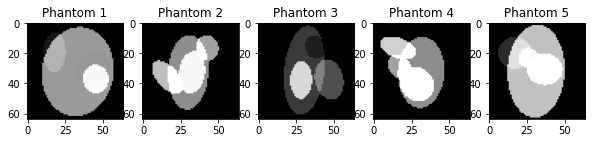

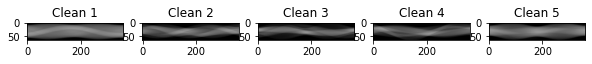

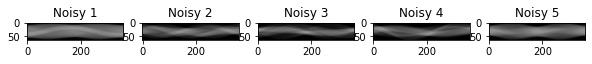

In [4]:
# Display some phantoms

fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for idx, ax in enumerate(axs):
    ax.imshow(np_phan[idx], cmap=plt.cm.Greys_r, vmin=0, vmax=1)
    ax.set_title(f"Phantom {idx+1}")
fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for idx, ax in enumerate(axs):
    ax.imshow(np_clean[idx], cmap=plt.cm.Greys_r, vmin=0, vmax=1)
    ax.set_title(f"Clean {idx+1}")
fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for idx, ax in enumerate(axs):
    ax.imshow(np_noisy[idx], cmap=plt.cm.Greys_r, vmin=0, vmax=1)
    ax.set_title(f"Noisy {idx+1}")
plt.show()

## Model 1: CNN

In [18]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input, InputLayer
model = keras.Sequential([
    Conv2D(2, (3,3), activation='relu', padding='same', strides=1, use_bias=False),
    Conv2D(2, (3,3), activation='relu', padding='same', strides=1, use_bias=False),
    Conv2D(2, (3,3), activation='relu', padding='same', strides=1, use_bias=False),
    Conv2D(1, (3,3), activation='relu', padding='same', use_bias=False)
])

## Model 2 : U-Net version 1

In [5]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input, InputLayer
model = keras.Sequential([
 layers.Conv2D(15, 3, strides=2, activation="relu", padding="same"),
 layers.Conv2D(15, 3, activation="relu", padding="same"),
 layers.Conv2D(20, 3, strides=2, activation="relu", padding="same"),
 layers.Conv2D(20, 3, activation="relu", padding="same"),
 layers.Conv2D(25, 3, strides=2, padding="same", activation="relu"),
 layers.Conv2D(25, 3, activation="relu", padding="same"),
 layers.Conv2DTranspose(25, 3, activation="relu", padding="same"),
 layers.Conv2DTranspose(25, 3, activation="relu", padding="same", strides=2),
 layers.Conv2DTranspose(20, 3, activation="relu", padding="same"),
 layers.Conv2DTranspose(20, 3, activation="relu", padding="same", strides=2),
 layers.Conv2DTranspose(15, 3, activation="relu", padding="same"),
 layers.Conv2DTranspose(15, 3, activation="relu", padding="same", strides=2),
 layers.Conv2D(1, 3, activation="relu", padding="same")
])

## Model 2: U-Net

In [ ]:
def get_model(img_size, num_classes):
 inputs = keras.Input(shape=img_size + (3,))
 x = layers.Rescaling(1./255)(inputs) 
 x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
 x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
 x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
 x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
 x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
 x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
 x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
 x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
 outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x) 
 model = keras.Model(inputs, outputs)
 return model
img_size = (64, 64)
model = get_model(img_size=img_size, num_classes=3)
model.summary()

In [6]:
model.compile(optimizer='adam', loss='mse')


#optimizer = keras.optimizers.Adam(lr=0.01)
#model.compile(loss='mse', optimizer=optimizer)

model.fit(np_noisy, 
          np_clean, 
          epochs=100, 
          shuffle=True, 
          validation_data=(np_noisyV, np_cleanV))


Epoch 1/100
29/29 [==============================] - 17s 55ms/step - loss: 0.0215 - val_loss: 0.0077
Epoch 2/100
29/29 [==============================] - 1s 33ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 3/100
29/29 [==============================] - 1s 34ms/step - loss: 0.0014 - val_loss: 8.6749e-04
Epoch 4/100
29/29 [==============================] - 1s 36ms/step - loss: 6.8881e-04 - val_loss: 5.8371e-04
Epoch 5/100
29/29 [==============================] - 1s 36ms/step - loss: 5.1399e-04 - val_loss: 4.5814e-04
Epoch 6/100
29/29 [==============================] - 1s 33ms/step - loss: 4.1812e-04 - val_loss: 3.7789e-04
Epoch 7/100
29/29 [==============================] - 1s 33ms/step - loss: 3.4013e-04 - val_loss: 3.2577e-04
Epoch 8/100
29/29 [==============================] - 1s 35ms/step - loss: 4.9218e-04 - val_loss: 3.8284e-04
Epoch 9/100
29/29 [==============================] - 1s 36ms/step - loss: 3.1250e-04 - val_loss: 2.7899e-04
Epoch 10/100
29/29 [===========================

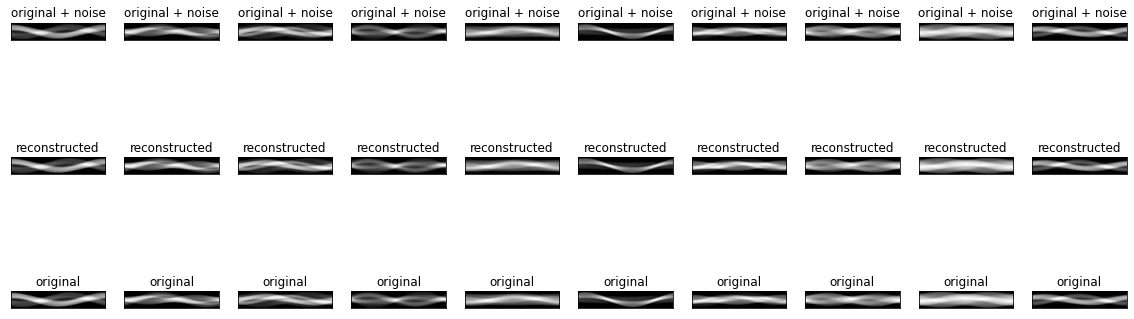

In [7]:
decoded_imgs=model(np_noisyV).numpy()

n = 10 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(np_noisyV[i])) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs[i])) 
  cx.get_xaxis().set_visible(False) 
  cx.get_yaxis().set_visible(False) 
  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(np_cleanV[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 

plt.show()

(1, 64, 360, 1)
(64, 360)


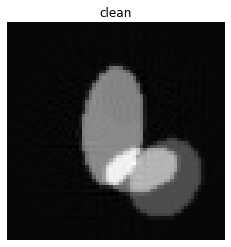

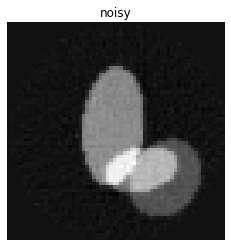

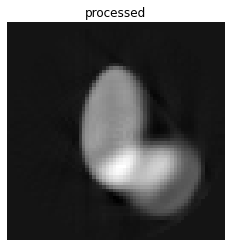

In [8]:
import numpy as np

x0 = np_noisyV[1,:,:,:]
x0 = np.expand_dims(x0, axis=0)
print(x0.shape)
y0 = model(x0).numpy()
z0 = np_cleanV[1,:,:,:]


x1 = np.squeeze(x0)
y1 = np.squeeze(y0)
z1 = np.squeeze(z0)
print(x1.shape)

fbpx = iradon(x1, theta=theta, filter_name='ramp')
fbpy = iradon(y1, theta=theta, filter_name='ramp')
fbpz = iradon(z1, theta=theta, filter_name='ramp')
plt.axis("off")
plt.imshow(fbpz),plt.title('clean')
plt.show()
plt.axis("off")
plt.imshow(fbpx),plt.title('noisy')
plt.show()
plt.axis("off")
plt.imshow(fbpy),plt.title('processed')
plt.show()


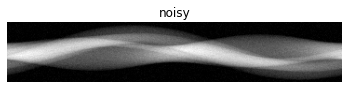

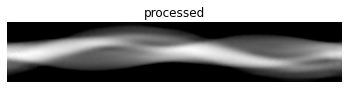

In [9]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(np.squeeze(x0[0]).astype("float")),plt.title('noisy')
plt.show()
plt.axis("off")
plt.imshow(np.squeeze(y0[0]).astype("float")),plt.title('processed')
plt.show()

In [10]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [11]:
activations = activation_model.predict(x0)

first_layer_activation = activations[0]
print(first_layer_activation.shape, first_layer_activation.shape[3])
second_layer_activation = activations[1]
print(second_layer_activation.shape, second_layer_activation.shape[3])
third_layer_activation = activations[2]
print(third_layer_activation.shape, third_layer_activation.shape[3])
fourth_layer_activation = activations[3]
print(fourth_layer_activation.shape, fourth_layer_activation.shape[3])


(1, 32, 180, 15) 15
(1, 32, 180, 15) 15
(1, 16, 90, 20) 20
(1, 16, 90, 20) 20


<ipython-input-37-5d8bb0e4e888>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.matshow(first_layer_activation[0, :, :, i], cmap=plt.cm.Greys_r,),plt.title('Layer 1 output')


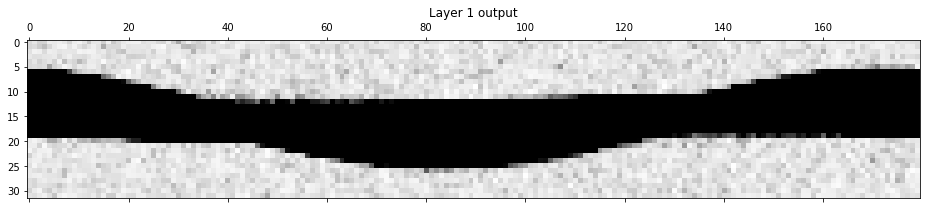

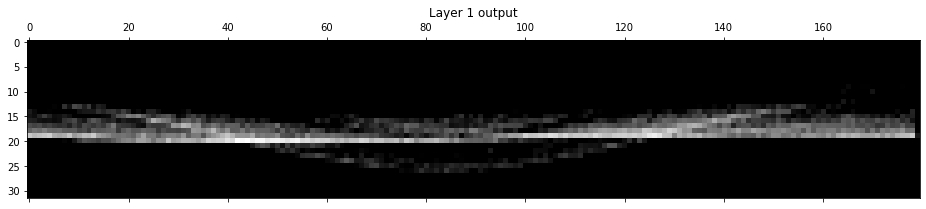

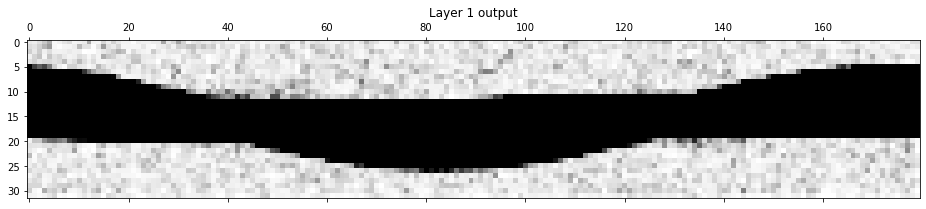

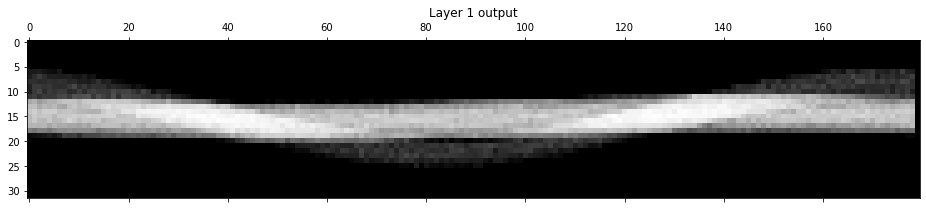

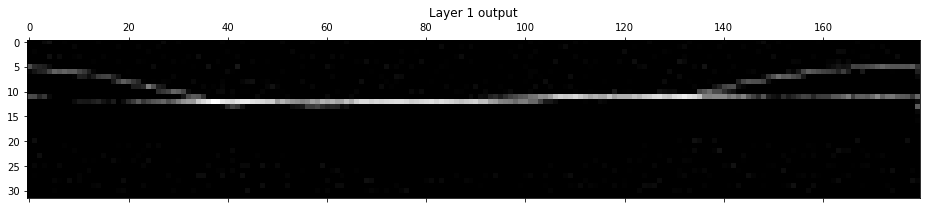

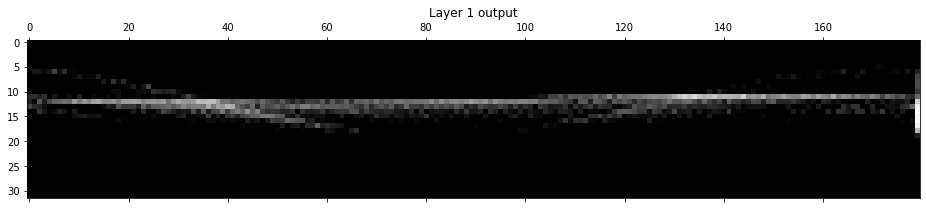

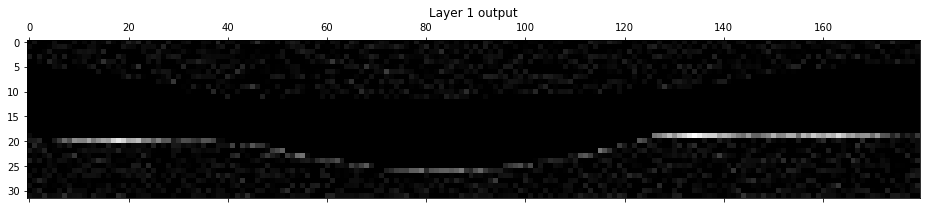

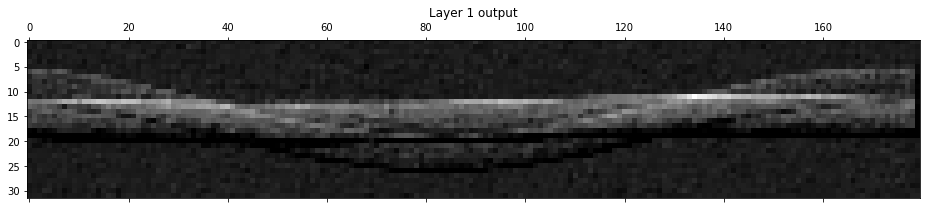

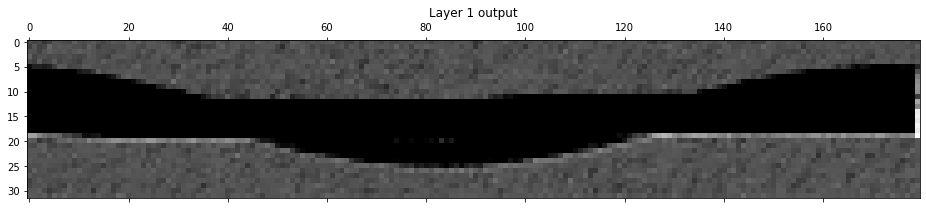

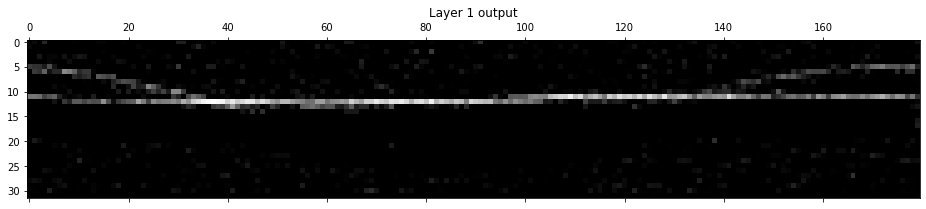

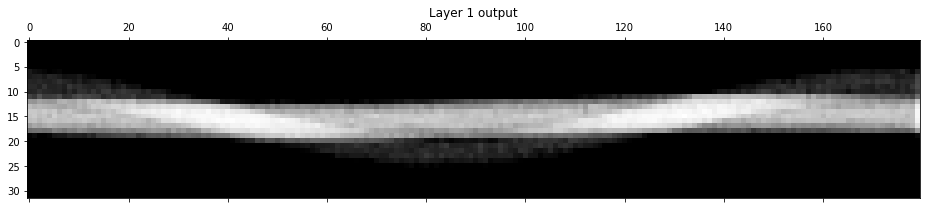

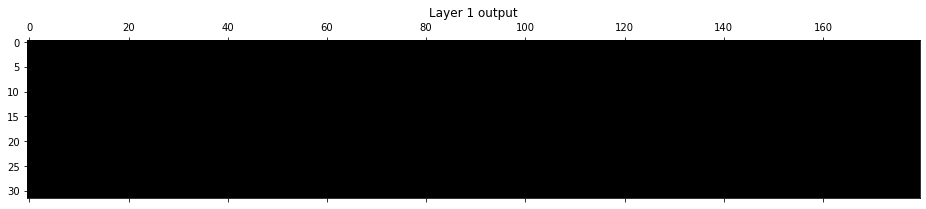

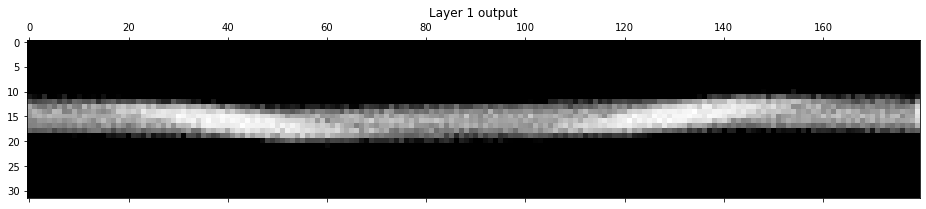

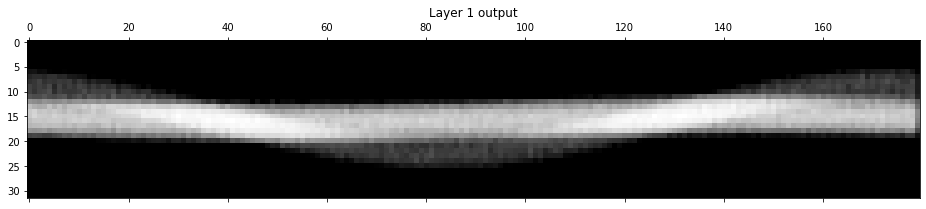

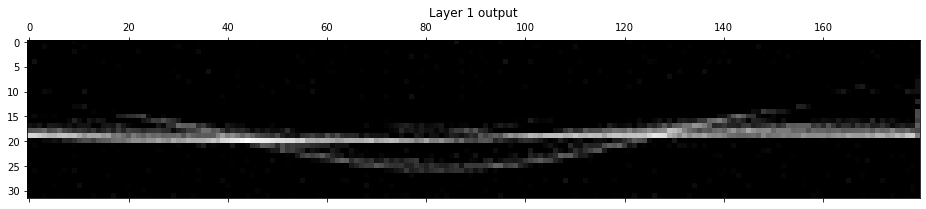

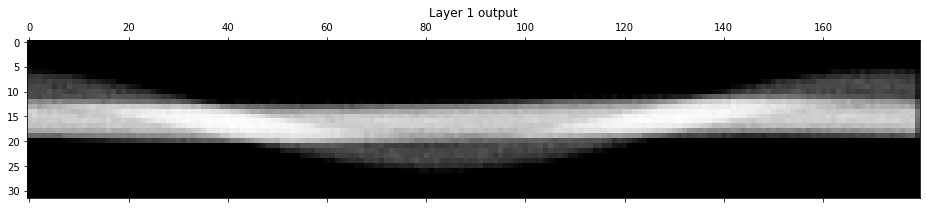

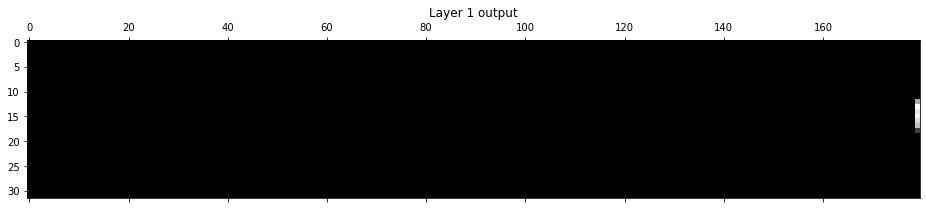

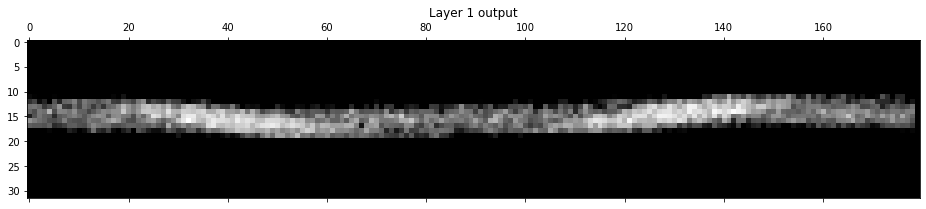

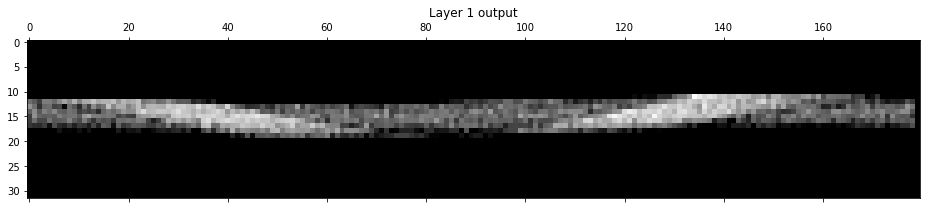

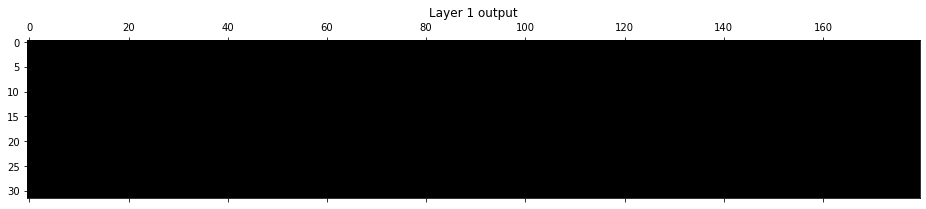

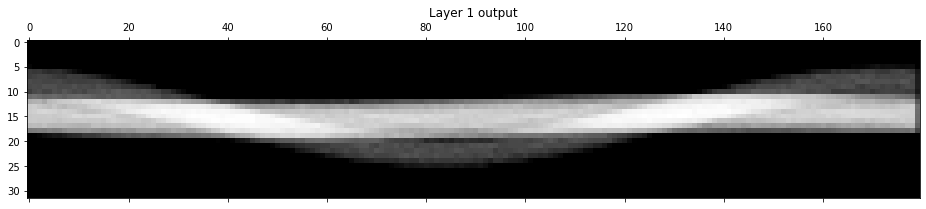

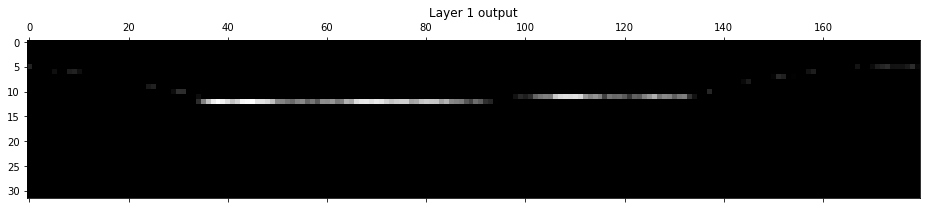

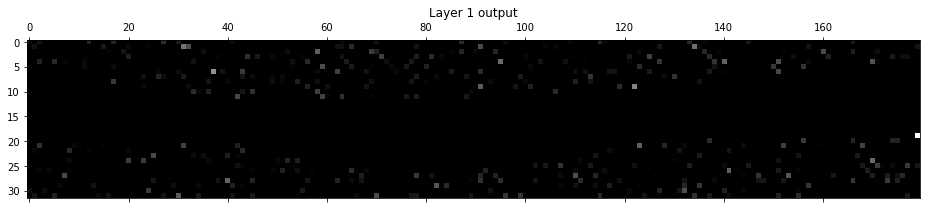

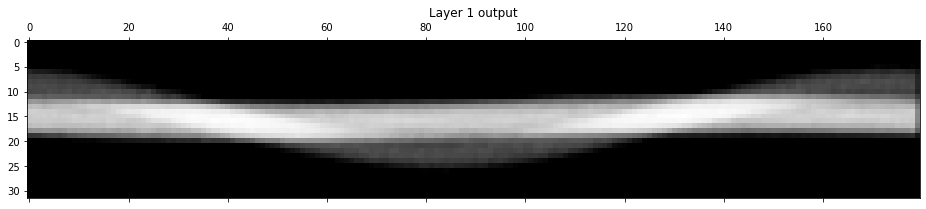

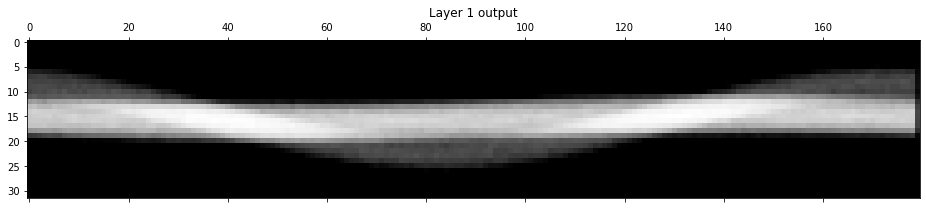

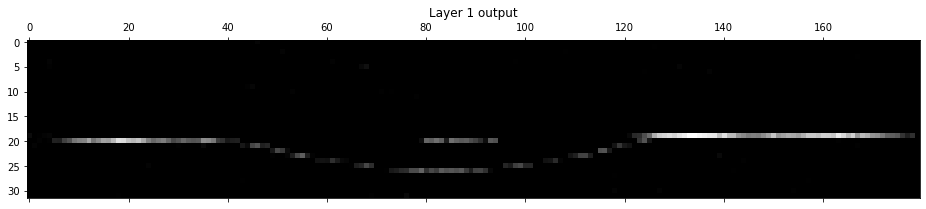

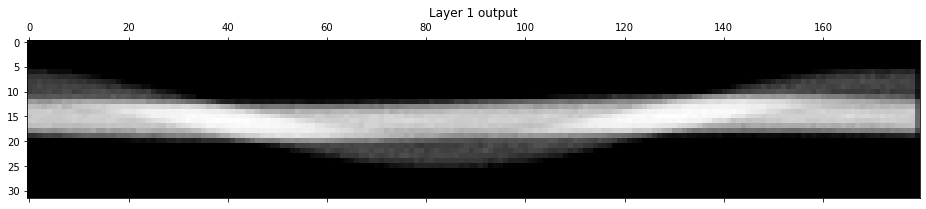

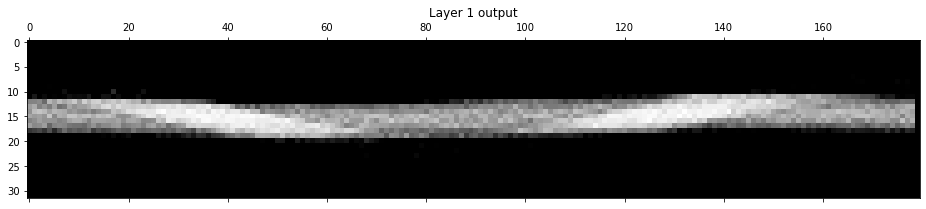

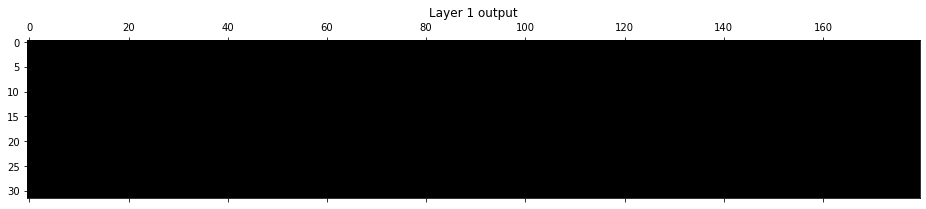

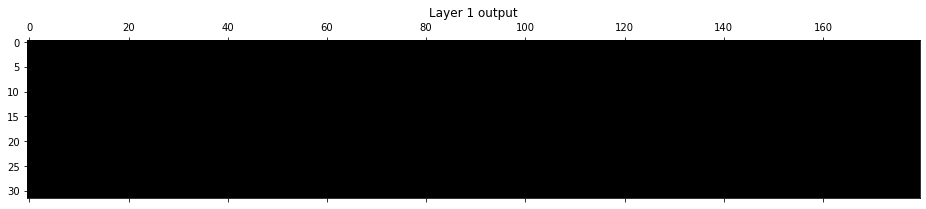

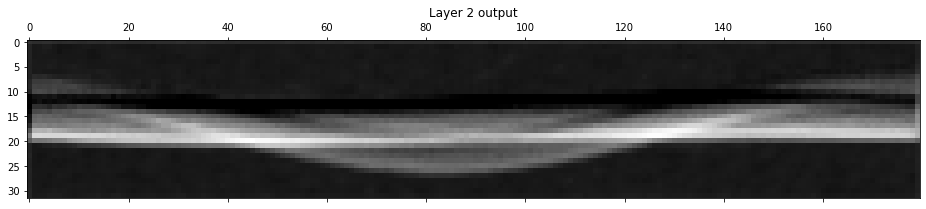

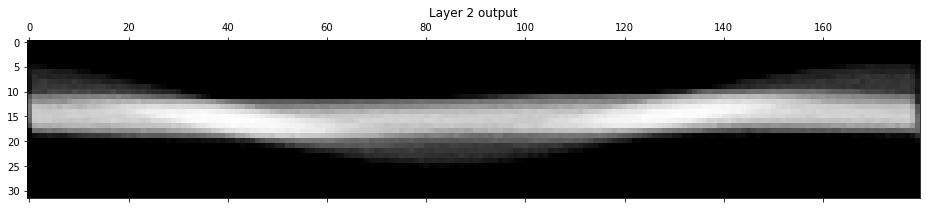

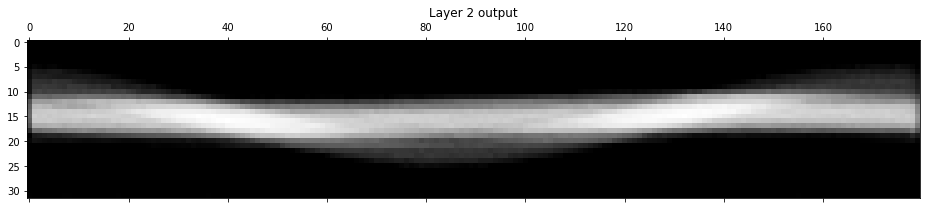

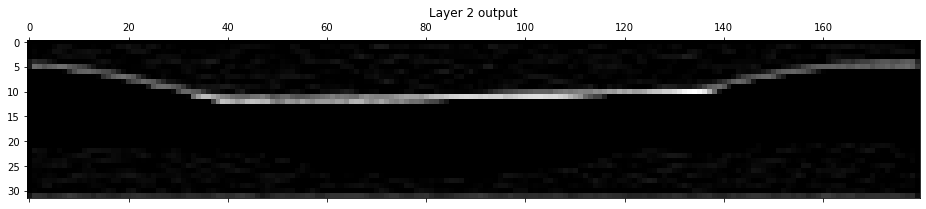

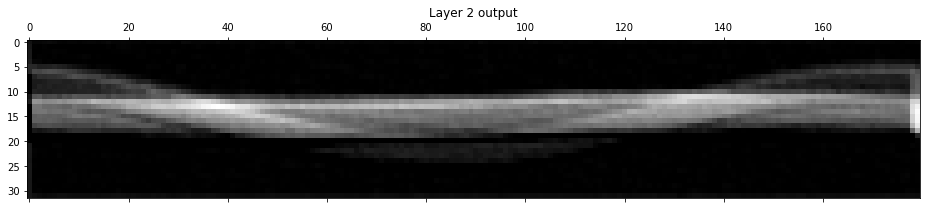

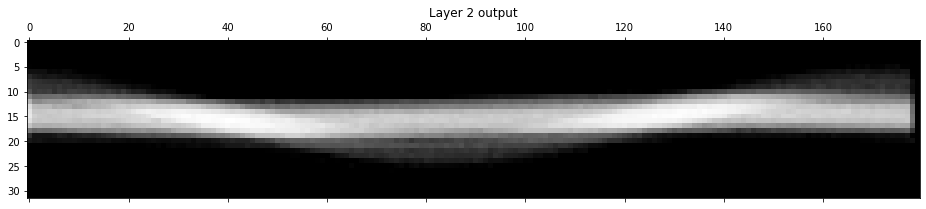

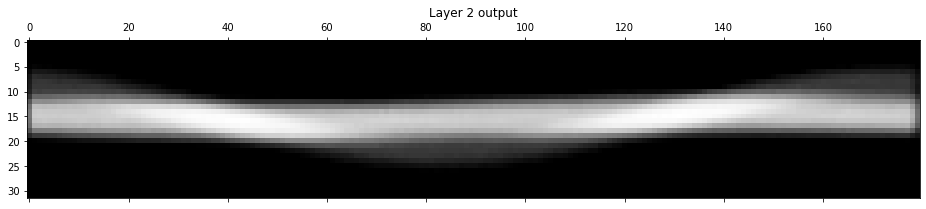

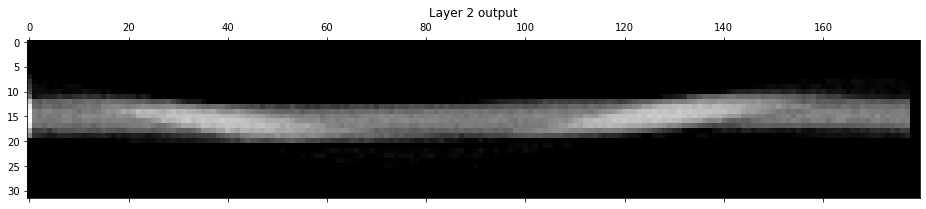

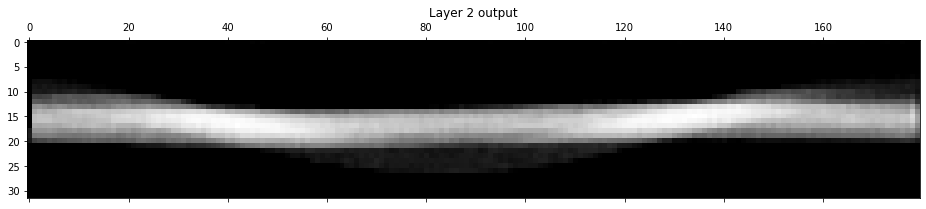

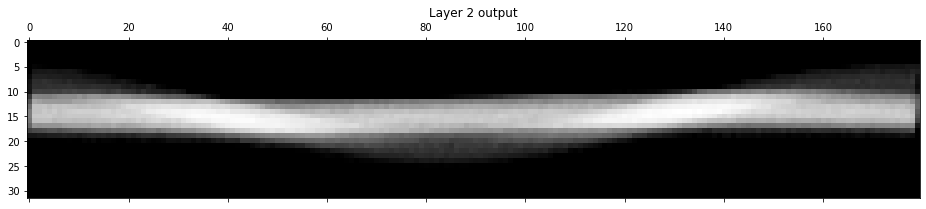

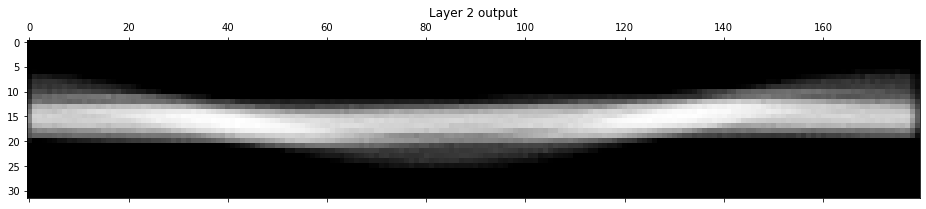

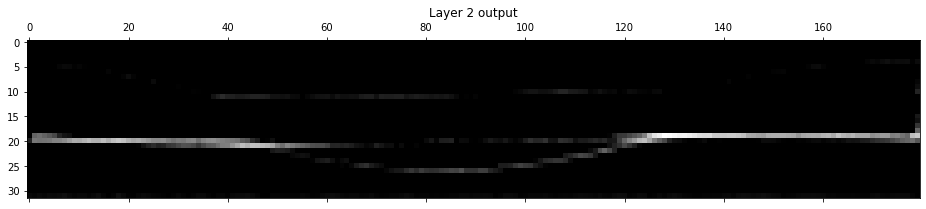

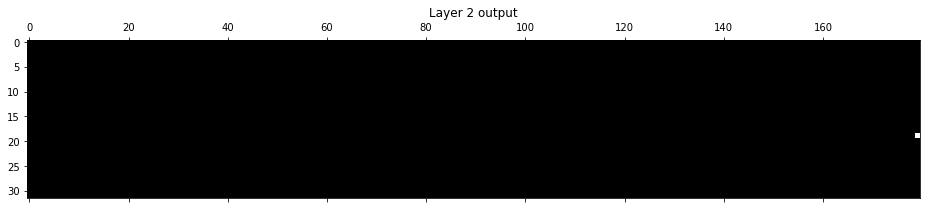

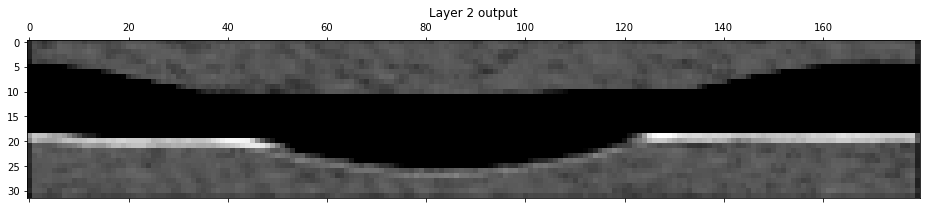

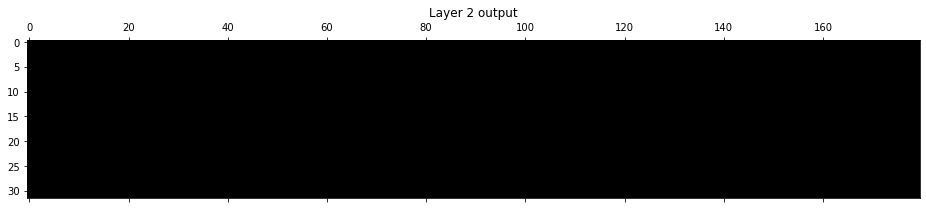

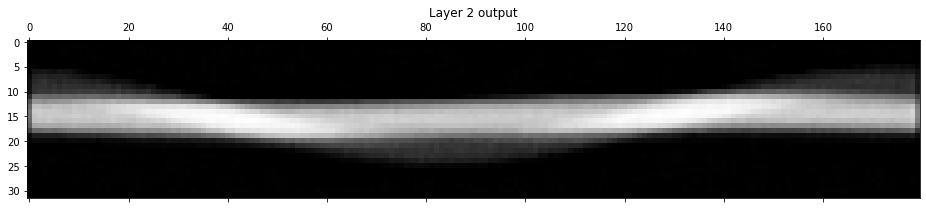

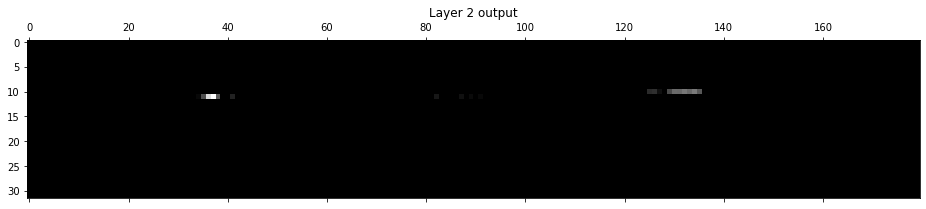

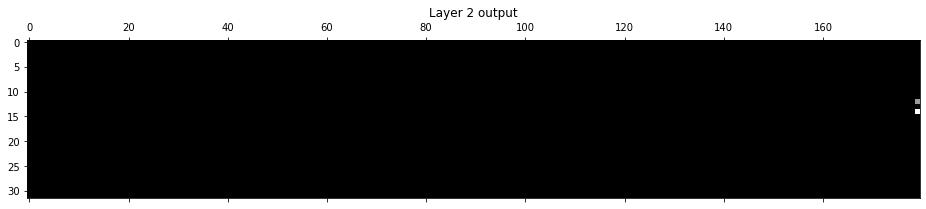

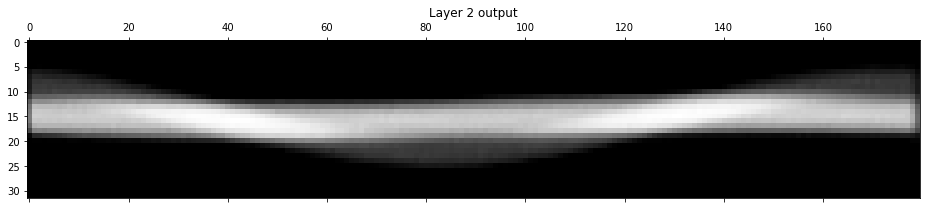

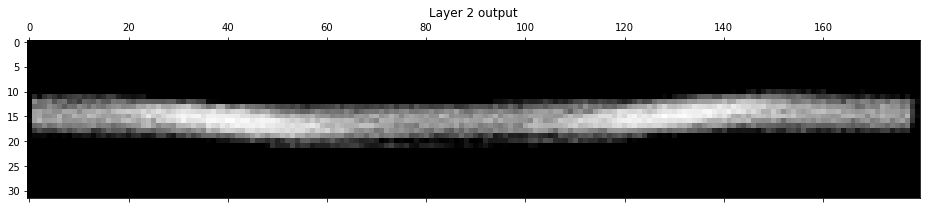

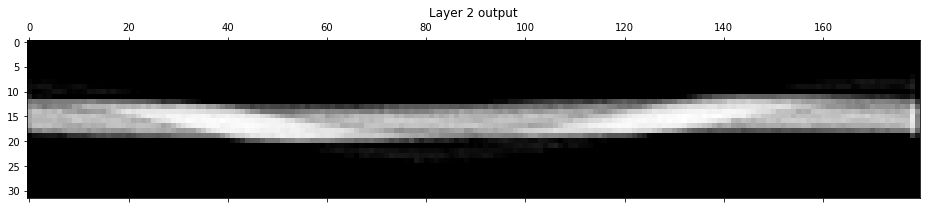

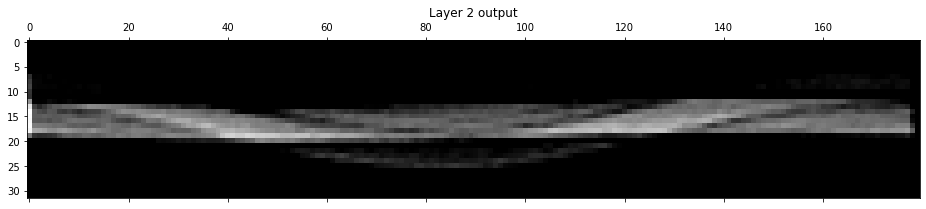

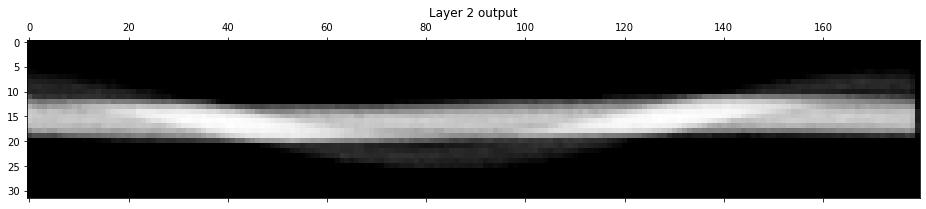

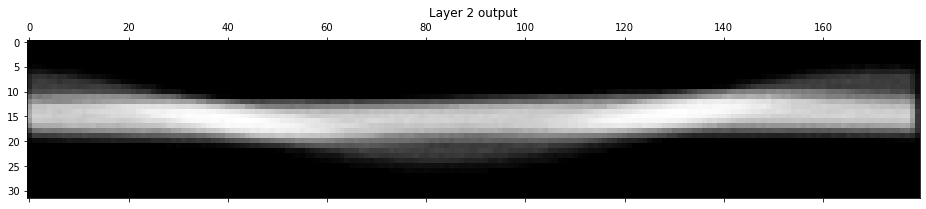

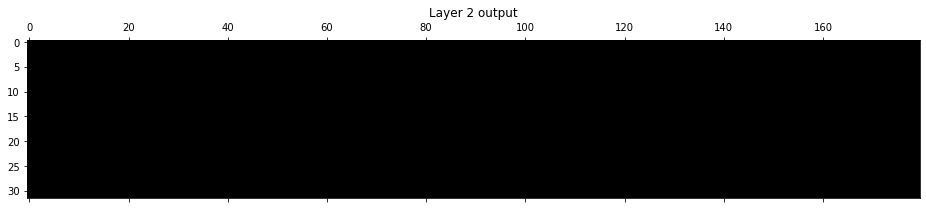

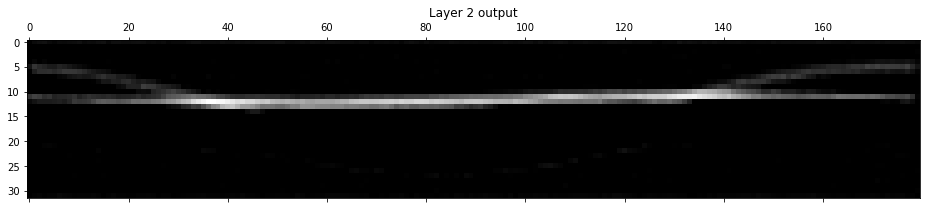

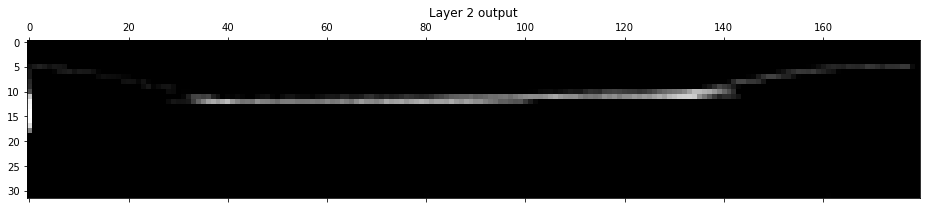

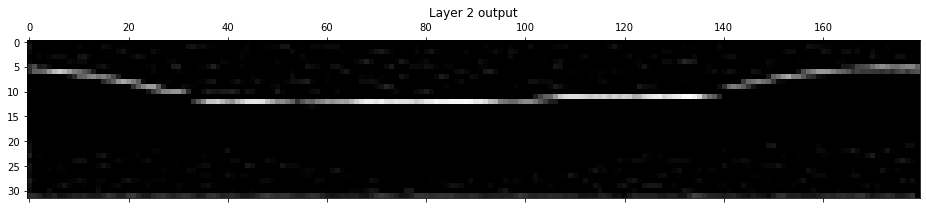

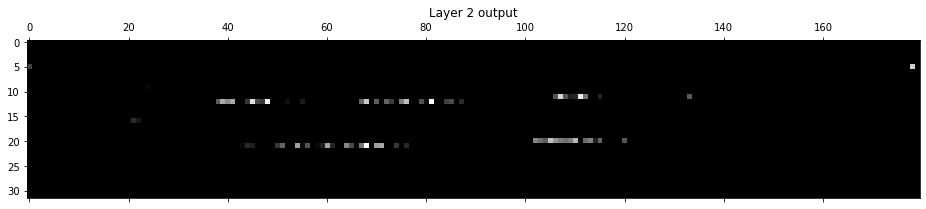

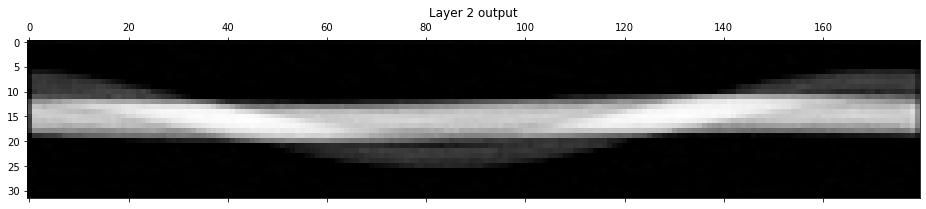

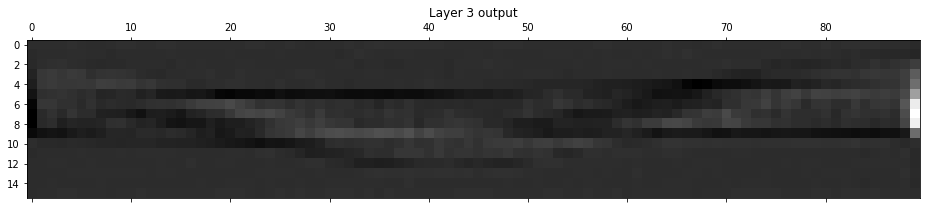

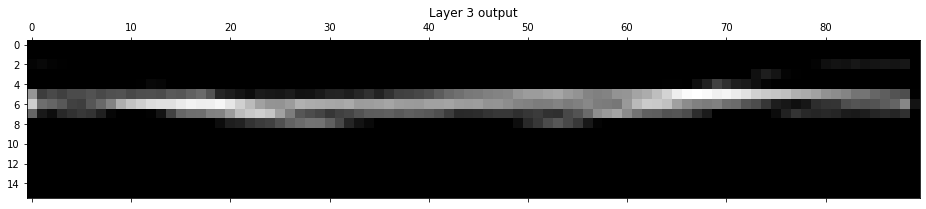

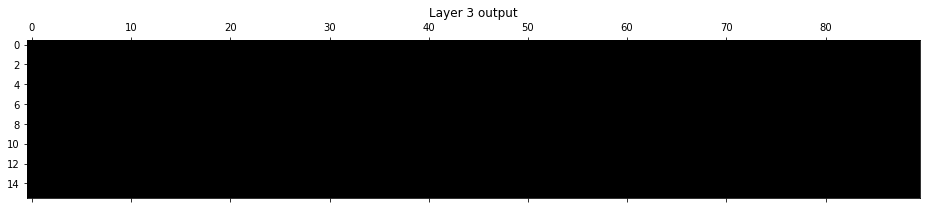

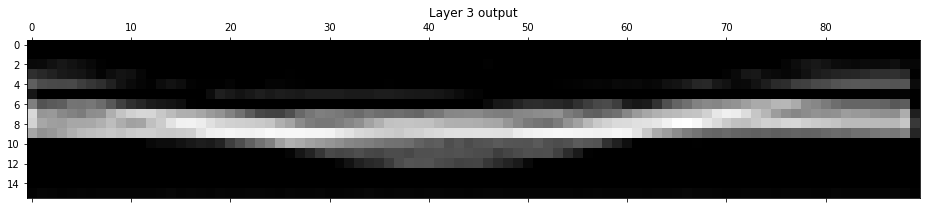

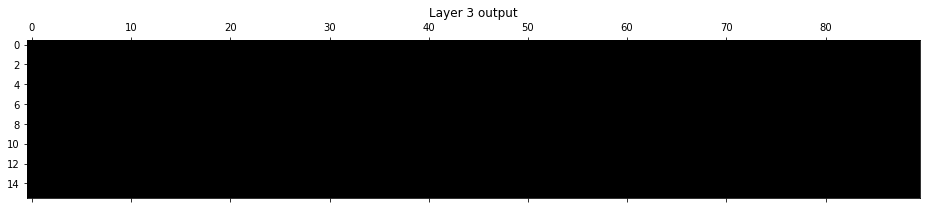

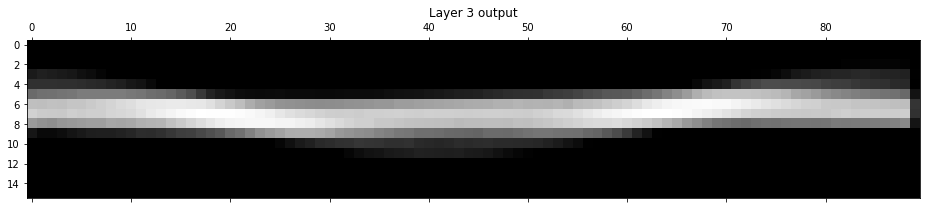

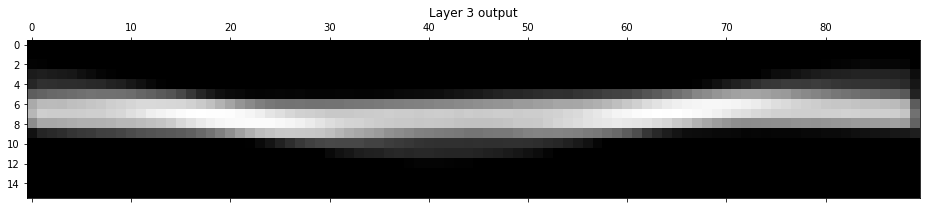

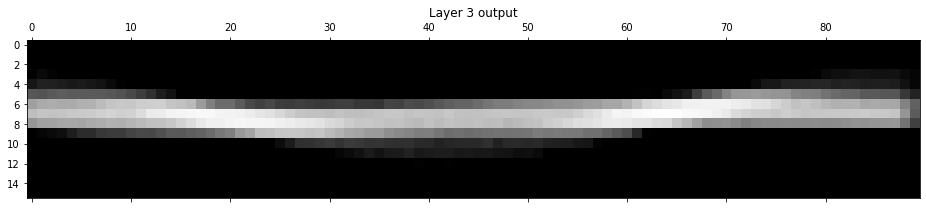

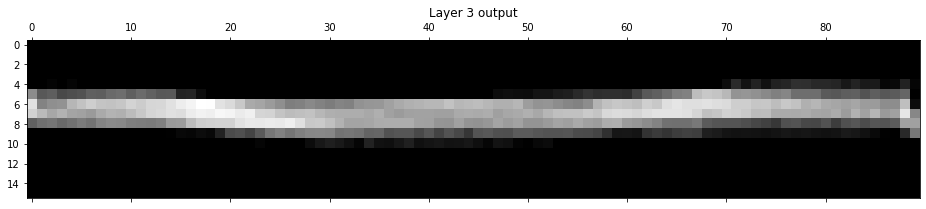

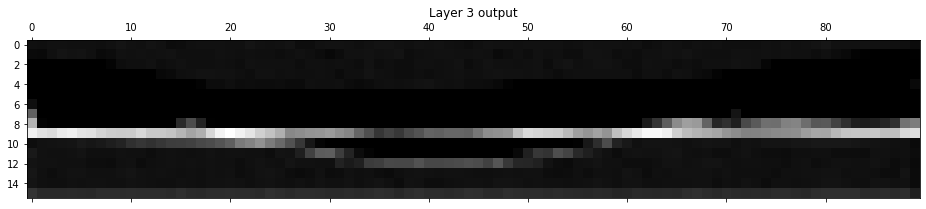

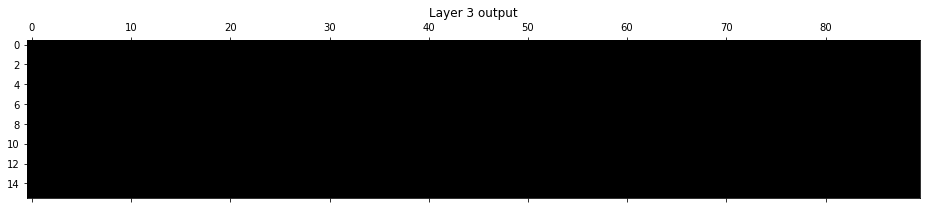

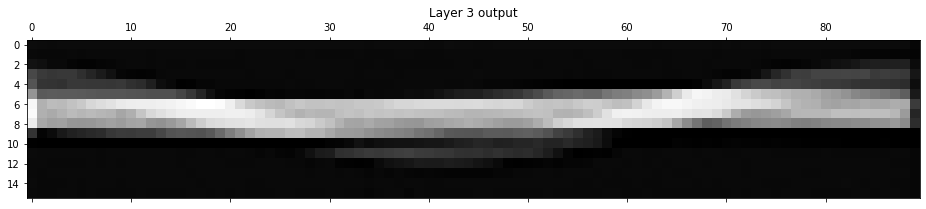

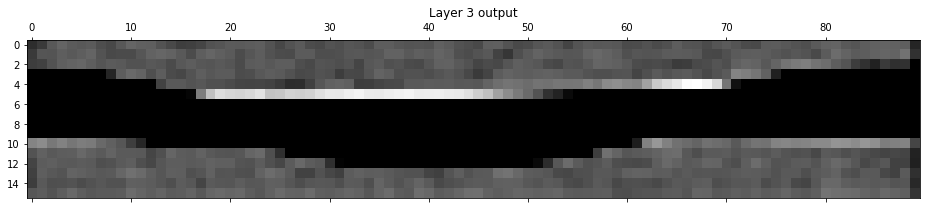

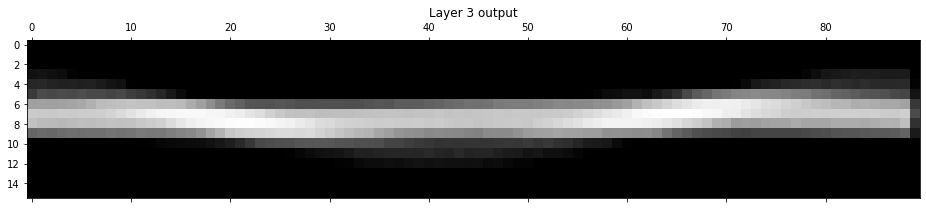

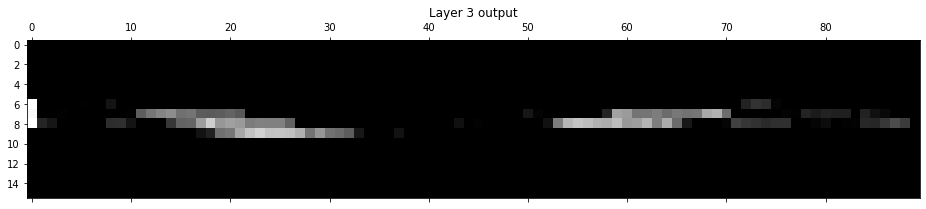

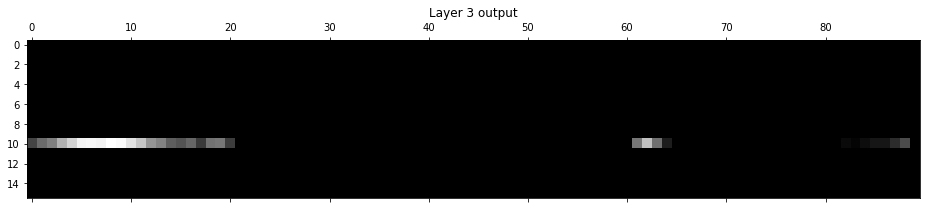

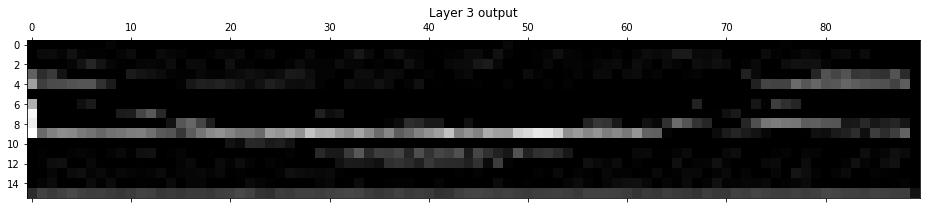

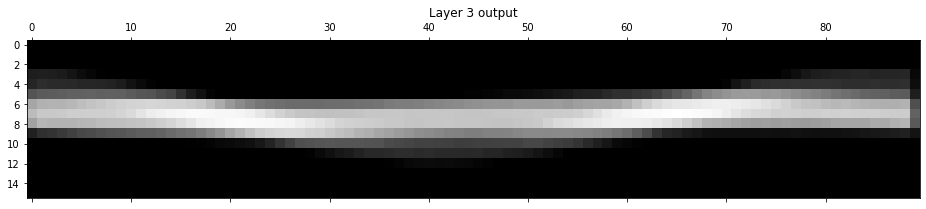

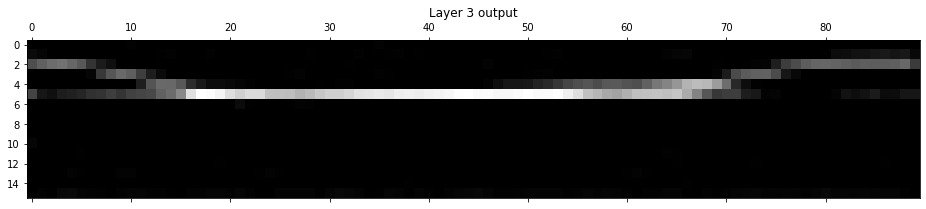

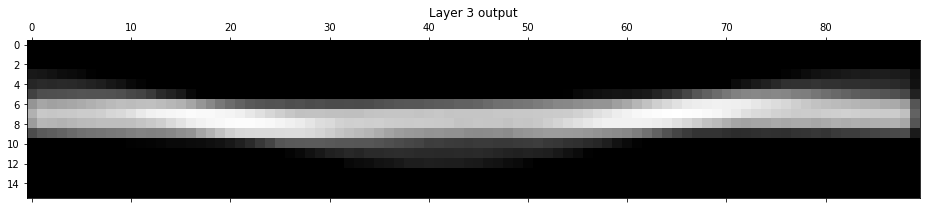

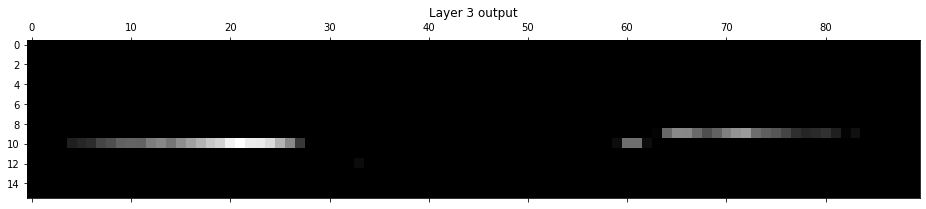

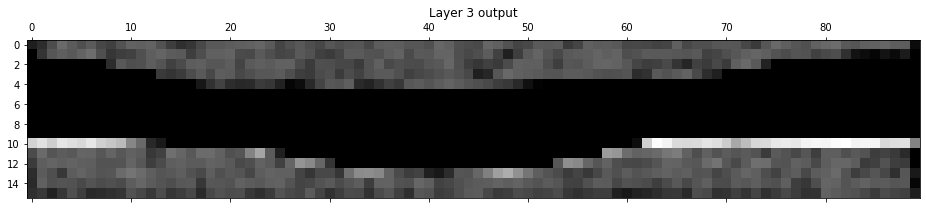

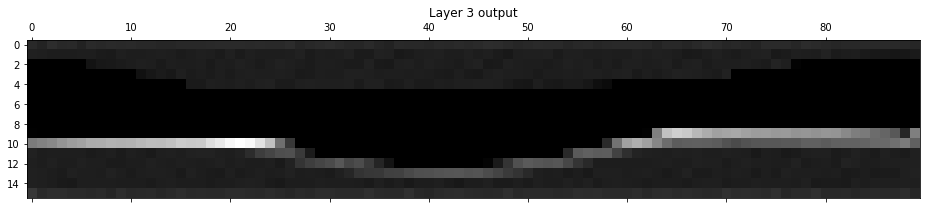

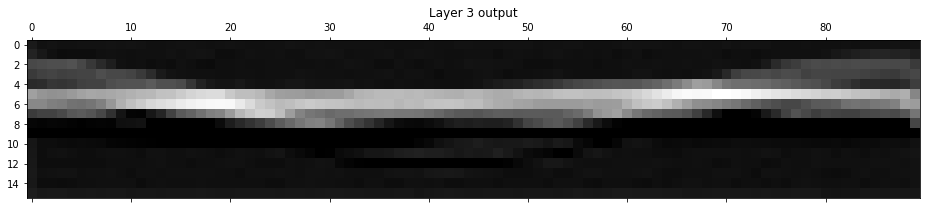

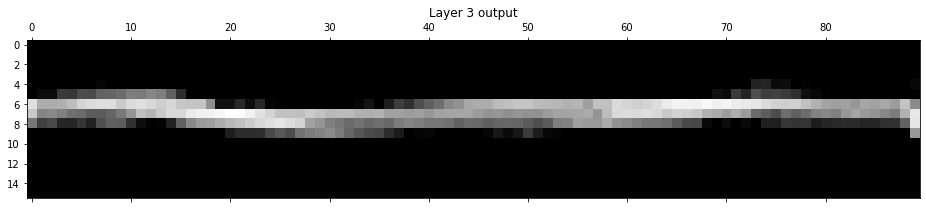

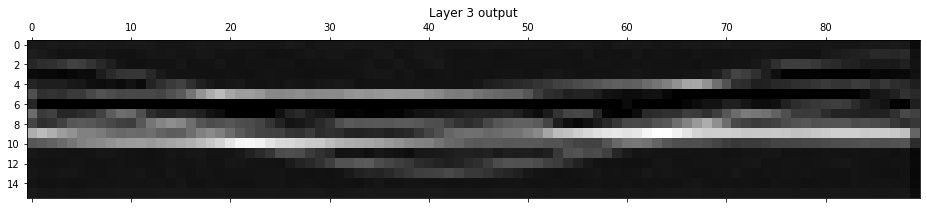

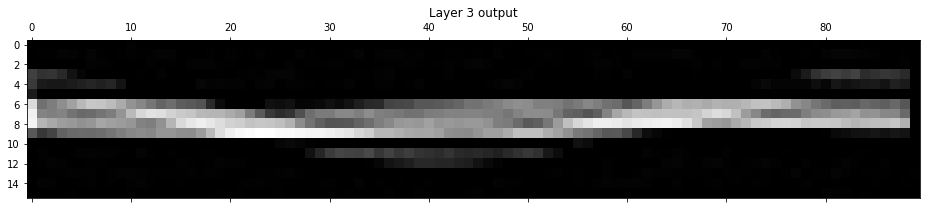

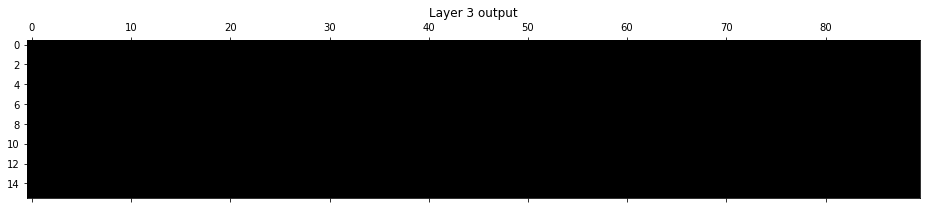

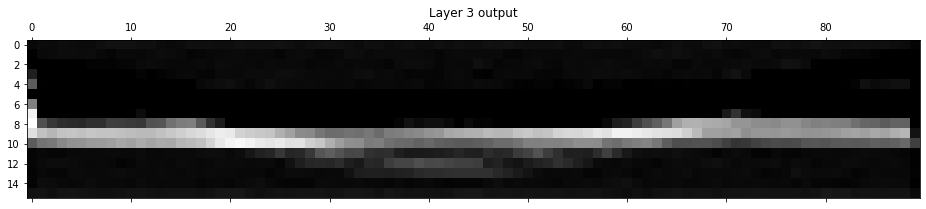

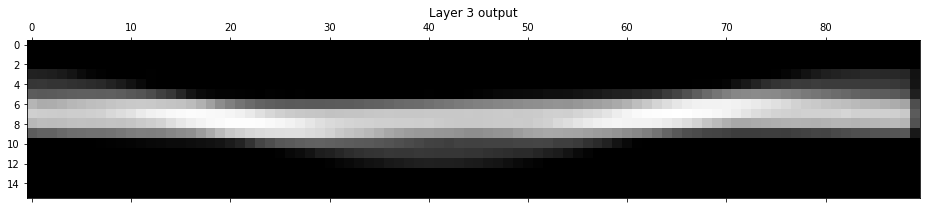

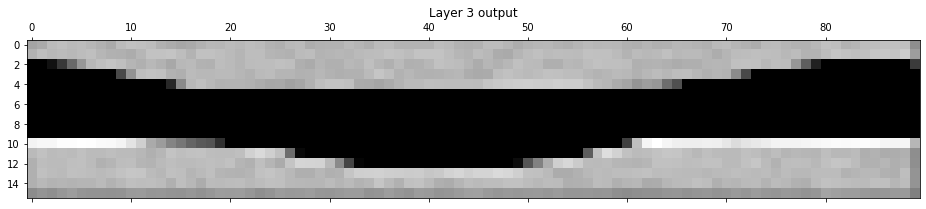

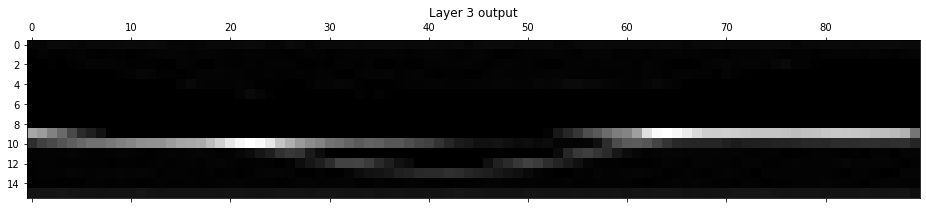

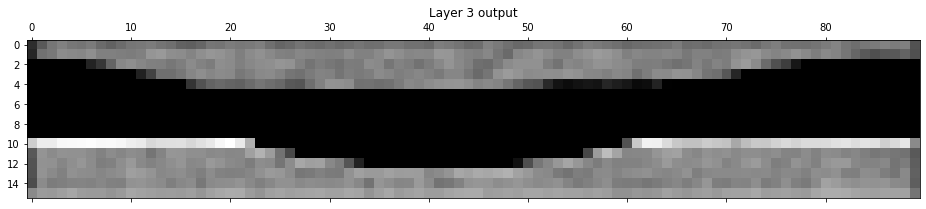

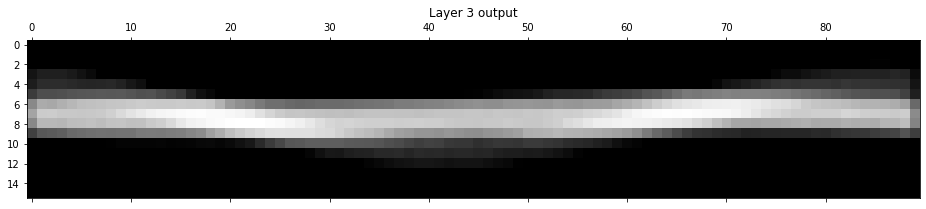

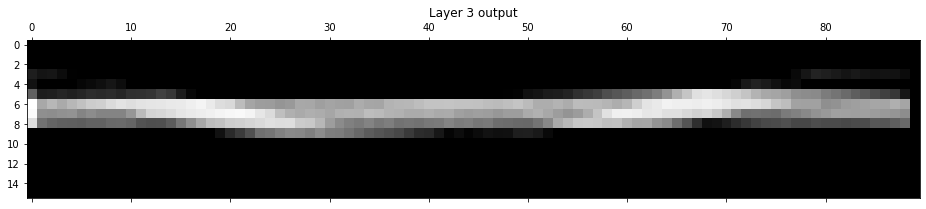

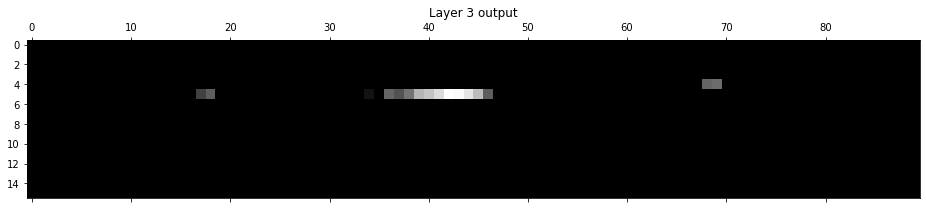

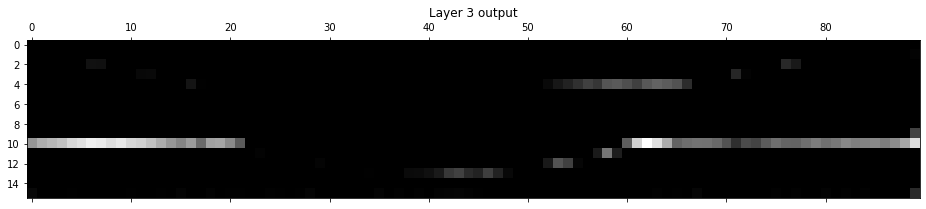

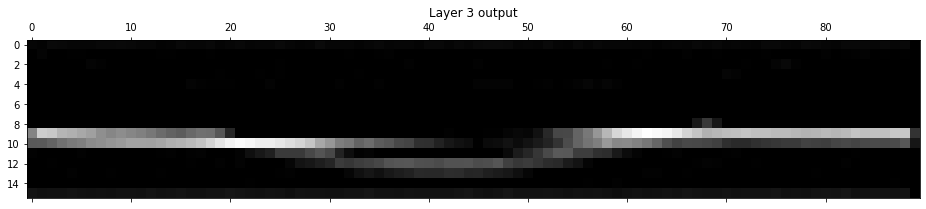

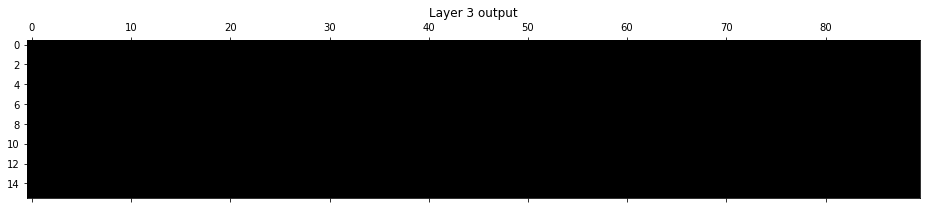

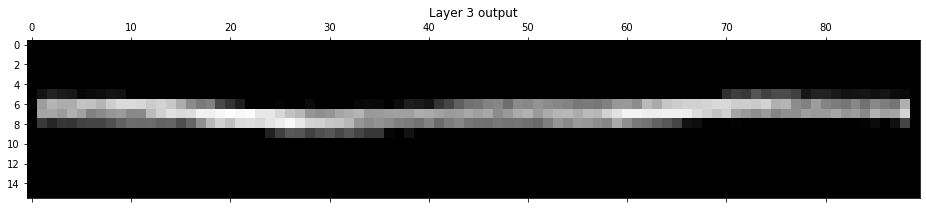

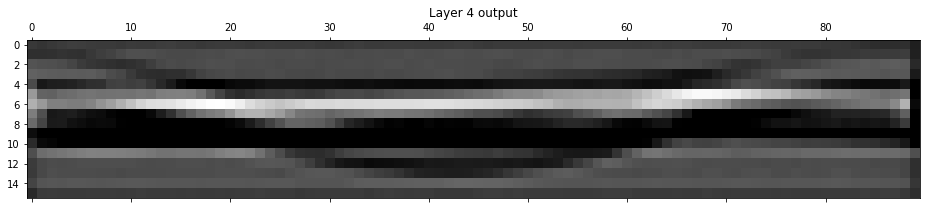

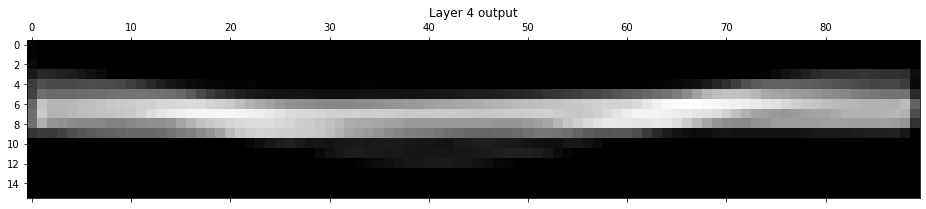

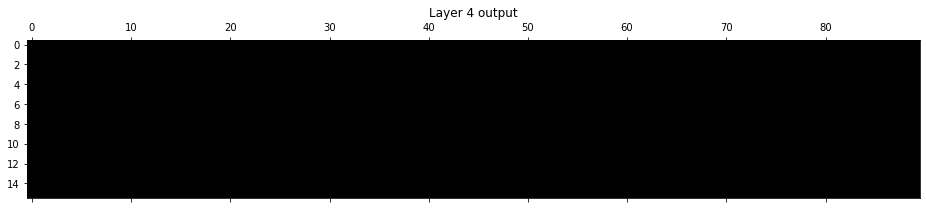

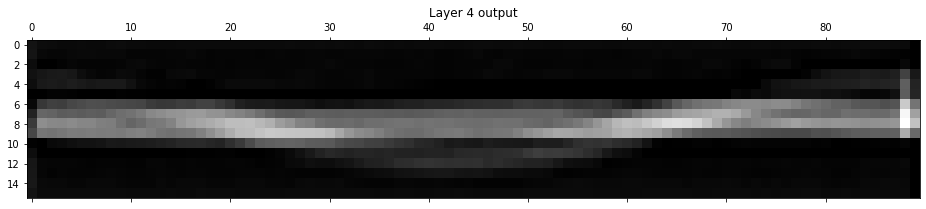

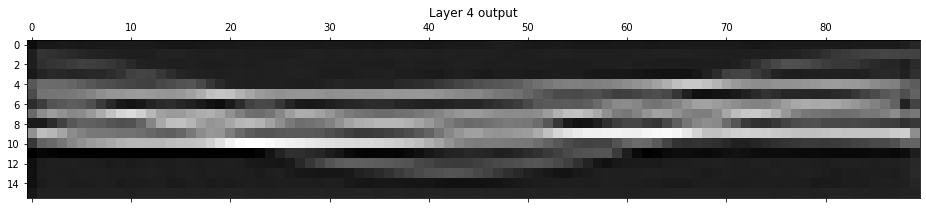

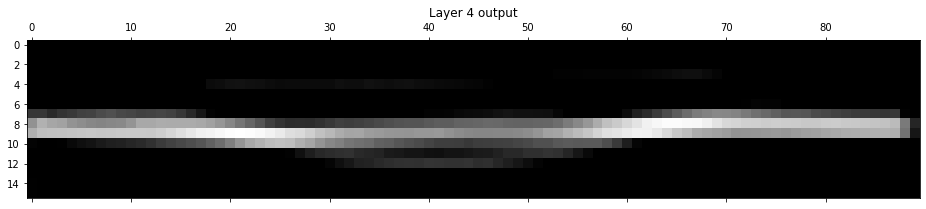

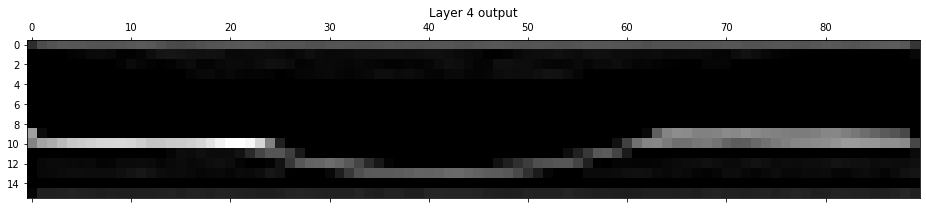

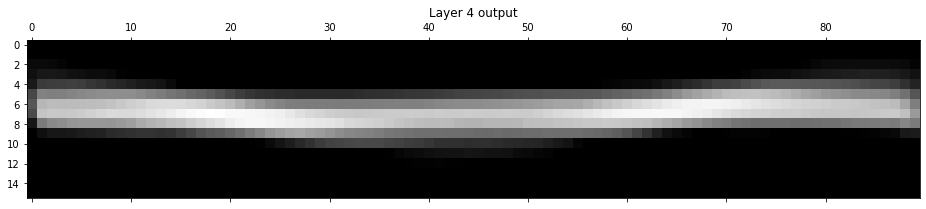

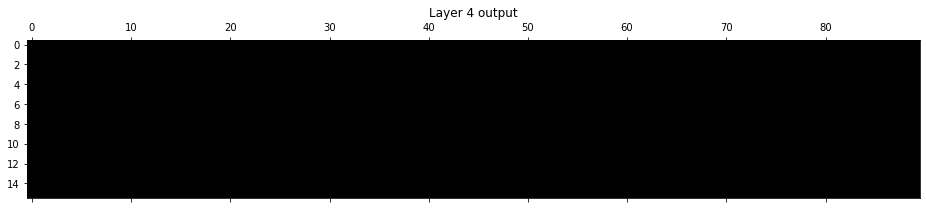

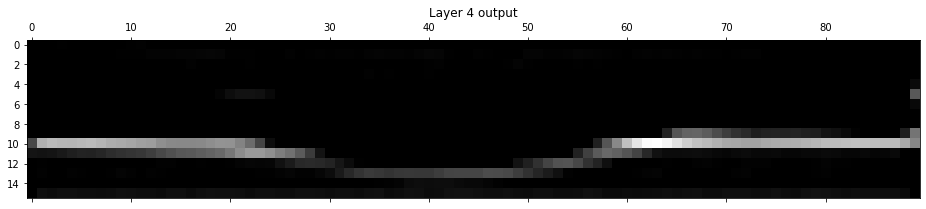

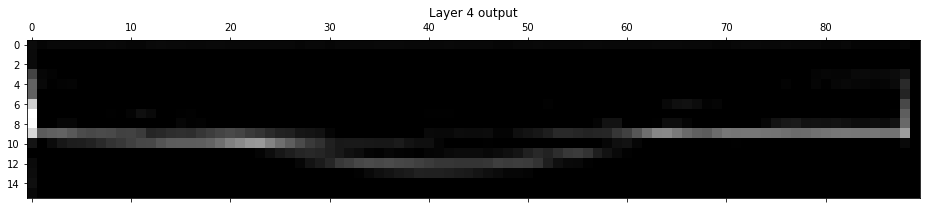

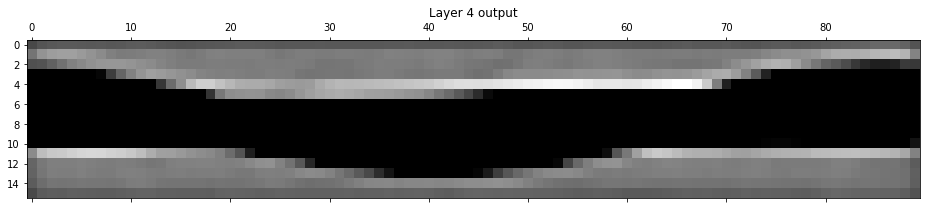

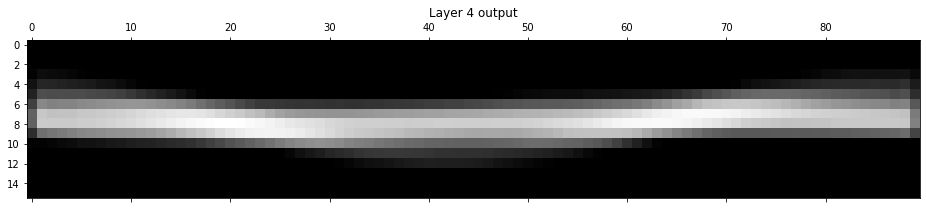

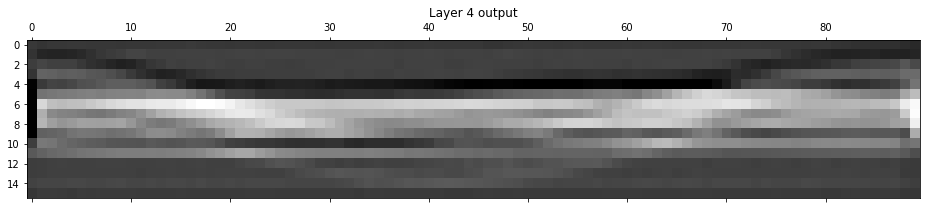

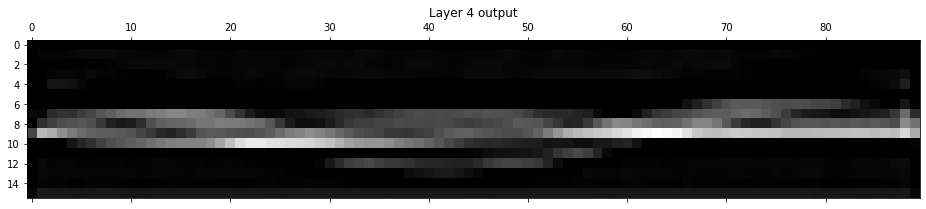

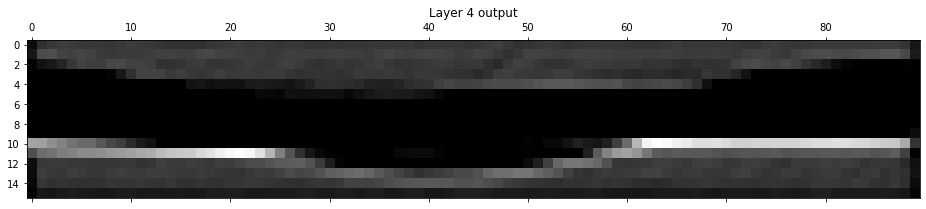

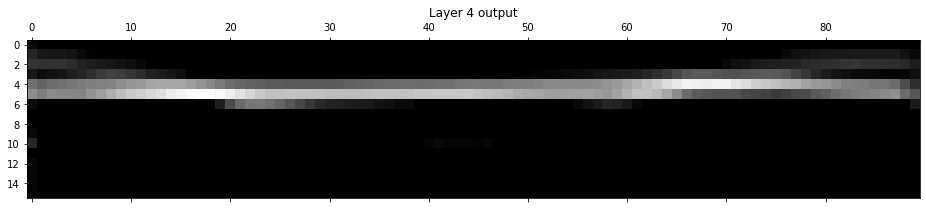

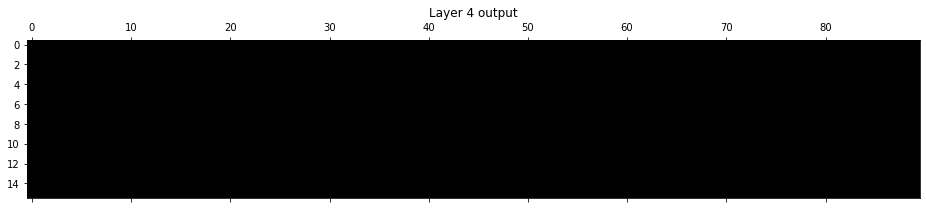

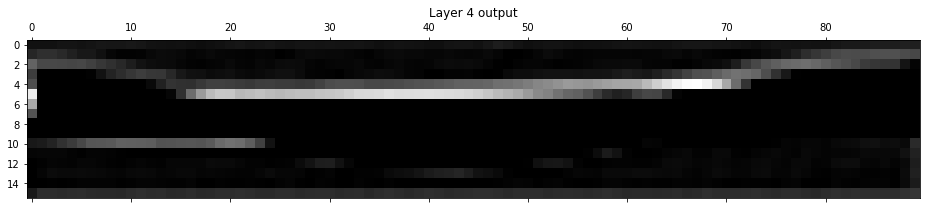

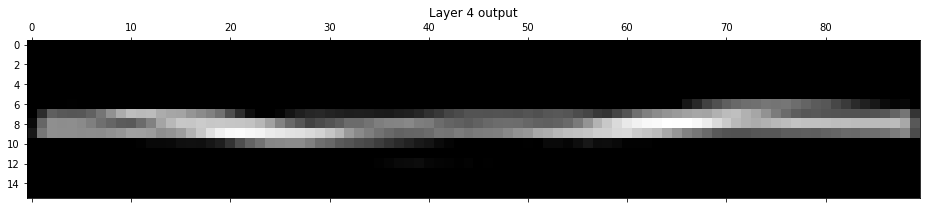

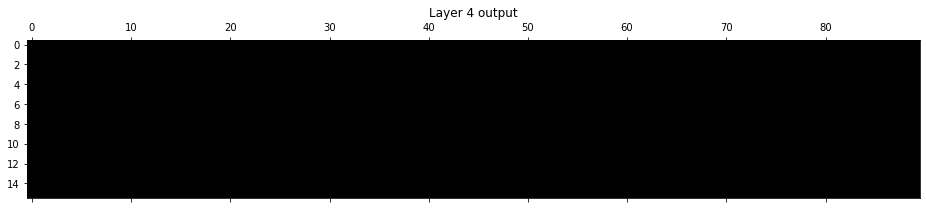

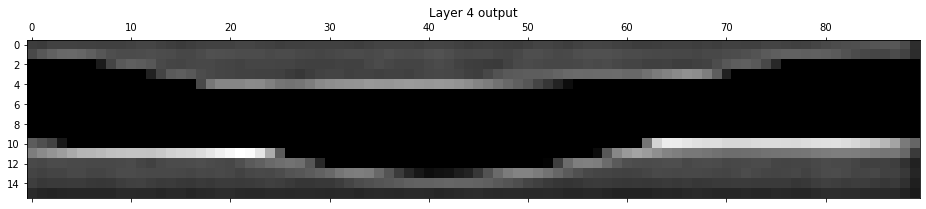

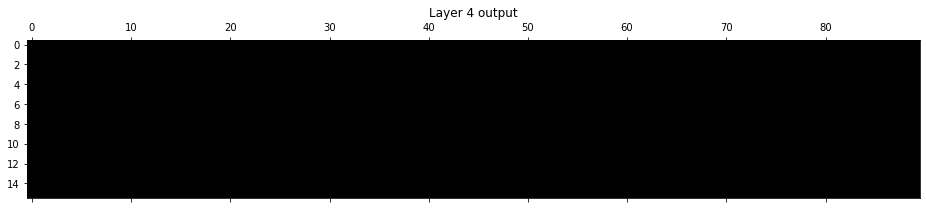

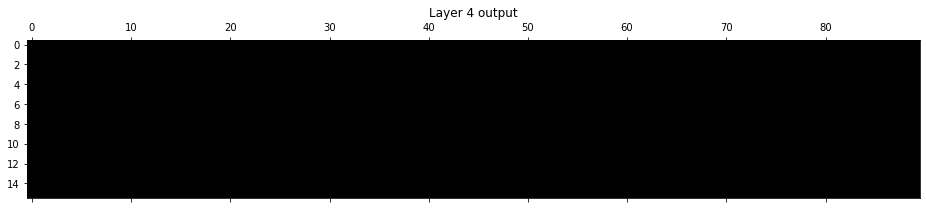

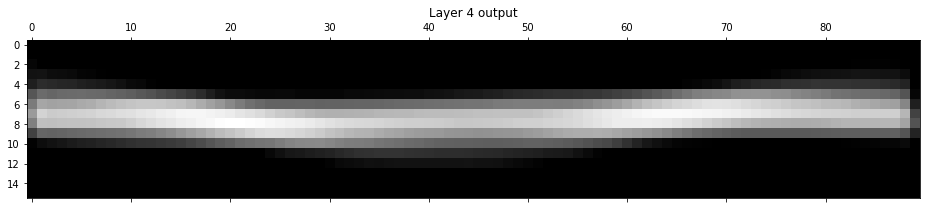

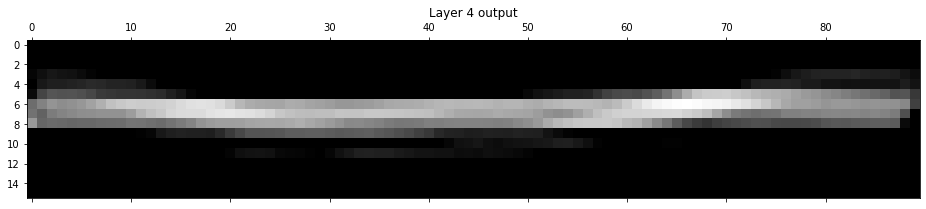

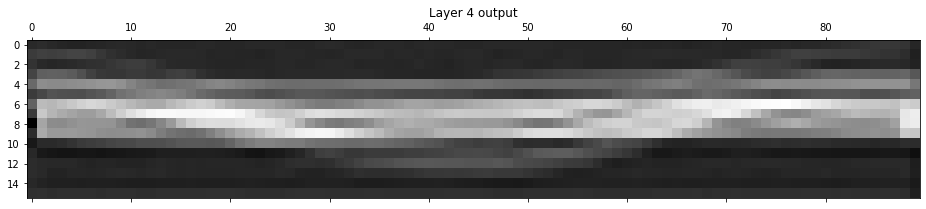

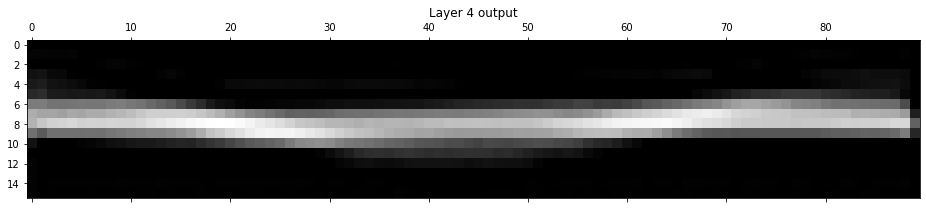

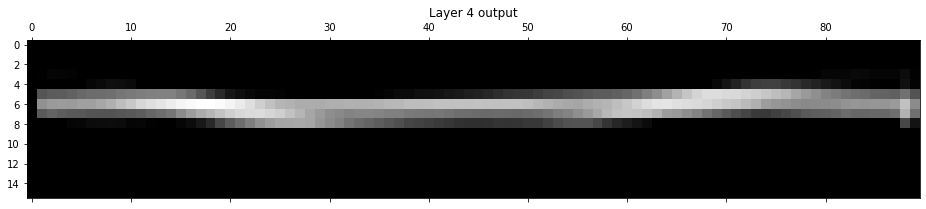

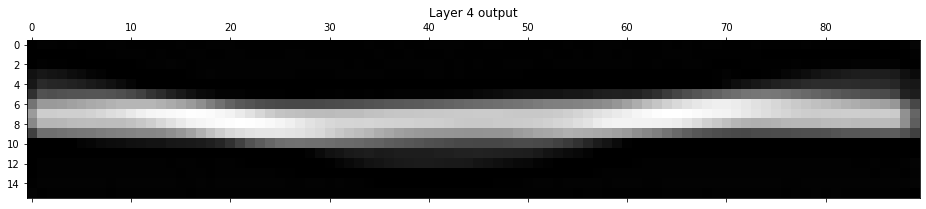

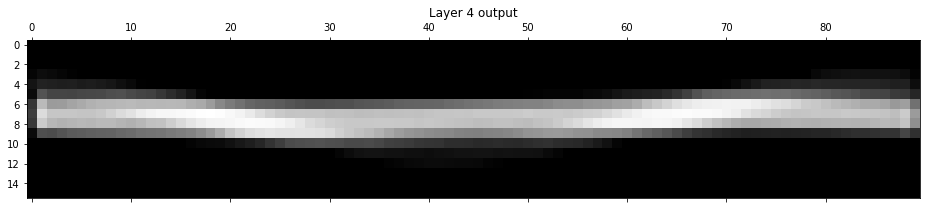

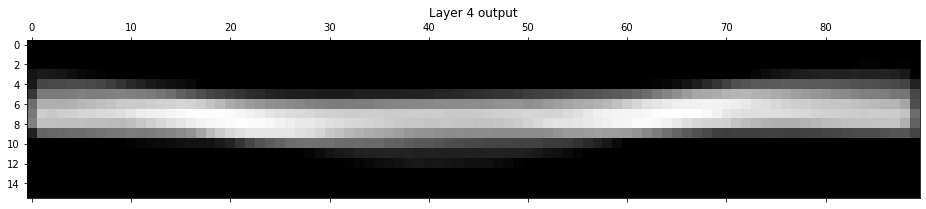

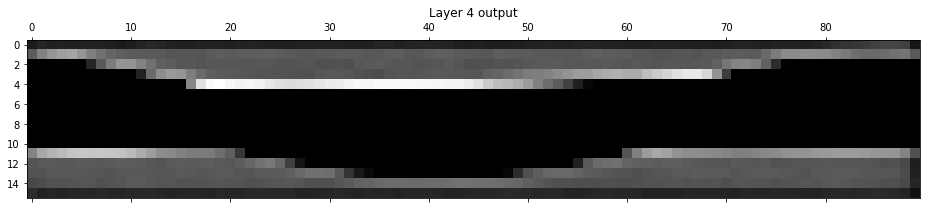

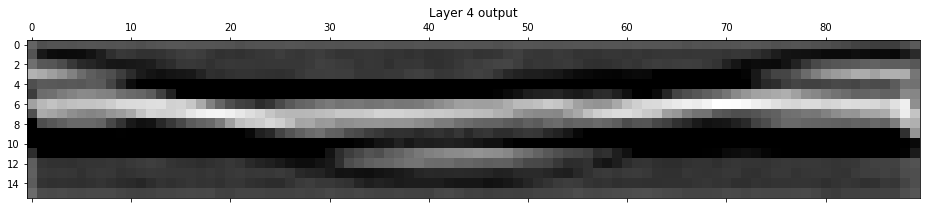

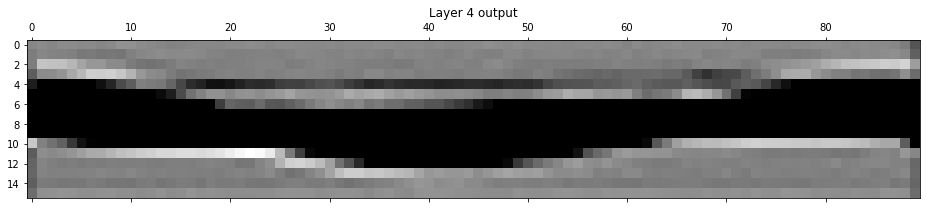

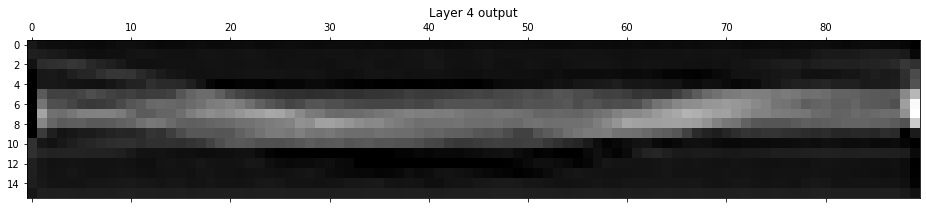

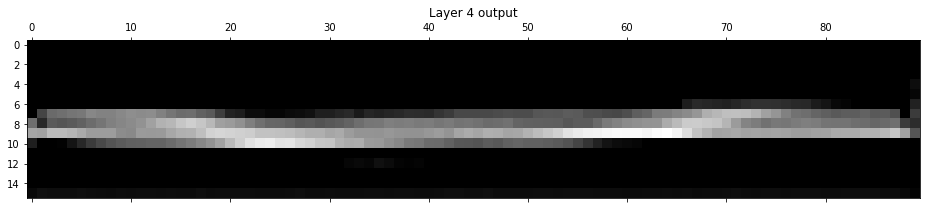

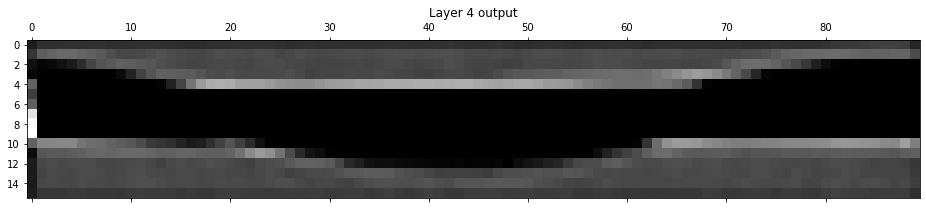

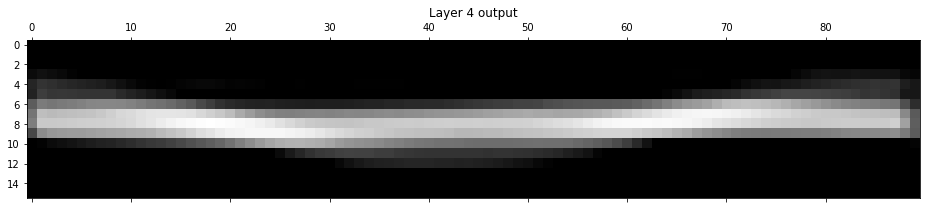

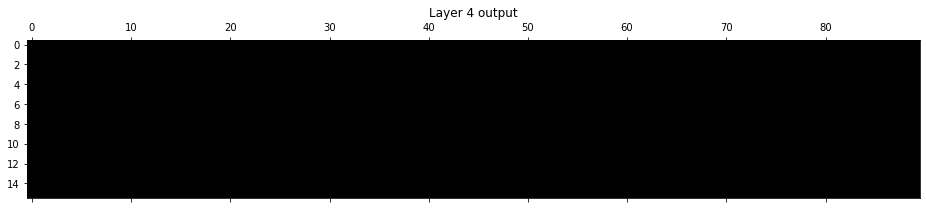

In [37]:
import matplotlib.pyplot as plt
for i in range(first_layer_activation.shape[3]):
    plt.matshow(first_layer_activation[0, :, :, i], cmap=plt.cm.Greys_r,),plt.title('Layer 1 output')
    
for i in range(second_layer_activation.shape[3]):
    plt.matshow(second_layer_activation[0, :, :, i], cmap=plt.cm.Greys_r,),plt.title('Layer 2 output')

for i in range(third_layer_activation.shape[3]):
    plt.matshow(third_layer_activation[0, :, :, i], cmap=plt.cm.Greys_r,),plt.title('Layer 3 output')

for i in range(fourth_layer_activation.shape[3]):
    plt.matshow(fourth_layer_activation[0, :, :, i], cmap=plt.cm.Greys_r,),plt.title('Layer 4 output')


In [38]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D)):
        print(layer.name)

conv2d_17
conv2d_18
conv2d_19
conv2d_20
conv2d_21
conv2d_22
conv2d_transpose_12
conv2d_transpose_13
conv2d_transpose_14
conv2d_transpose_15
conv2d_transpose_16
conv2d_transpose_17
conv2d_23


In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 180, 30)       300       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 180, 30)       8130      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 90, 40)        10840     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 90, 40)        14440     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 45, 50)         18050     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 45, 50)         22550     
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 45, 50)        

In [40]:
ZERO = model.layers[0].get_weights()[0]
ONE = model.layers[1].get_weights()[0]
TWO = model.layers[2].get_weights()[0]
THREE = model.layers[3].get_weights()[0]
print(ZERO.shape, ONE.shape, TWO.shape, THREE.shape) 
ZERO = np.transpose(ZERO, (3, 2, 0, 1 ))
ONE = np.transpose(ONE, (2, 3, 0, 1))
TWO = np.transpose(TWO, (2, 3, 0, 1))
THREE = np.transpose(THREE, (2, 3, 0, 1))
print('First layer weights =')
print(ZERO)
print('Second layer weights =')
print(ONE)
print('Third layer weights =')
print(TWO)
print('Fourth layer weights =')
print(THREE)

print(ZERO.shape) 
print(ONE.shape) 
print(TWO.shape) 
print(THREE.shape) 
# plt.matshow(ZERO[1, 0, :, :], cmap=plt.cm.Greys_r,)

(3, 3, 1, 30) (3, 3, 30, 30) (3, 3, 30, 40) (3, 3, 40, 40)
First layer weights =
[[[[-0.13112618  0.0798941   0.01281911]
   [-0.10308954 -0.1342929  -0.07168581]
   [-0.05511525  0.07440898 -0.07442386]]]


 [[[ 0.12548926 -0.02597804  0.12948532]
   [-0.09750661  0.03798383  0.0565416 ]
   [ 0.04540394 -0.13998313 -0.09343515]]]


 [[[-0.17401002 -0.04981301 -0.07174522]
   [-0.1081646  -0.18121941 -0.19964889]
   [-0.17968933 -0.2898177  -0.14651781]]]


 [[[-0.09481118 -0.10378721  0.09680562]
   [ 0.01889579  0.1295471   0.13695292]
   [ 0.00651491  0.01901005  0.0203423 ]]]


 [[[-0.09644497 -0.03195727 -0.17501445]
   [-0.03359761 -0.04171864 -0.12469048]
   [ 0.04321618  0.16353899  0.1299393 ]]]


 [[[ 0.08521927 -0.0848212  -0.1481575 ]
   [ 0.10140198 -0.00273064 -0.07808718]
   [-0.00991353  0.07149407  0.08730862]]]


 [[[-0.02159101  0.14039887  0.03775883]
   [-0.12126969 -0.02351114 -0.11397494]
   [ 0.03781388 -0.15071924 -0.07492857]]]


 [[[-0.1455958  -0.08535863 -0

30


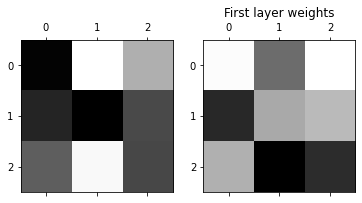

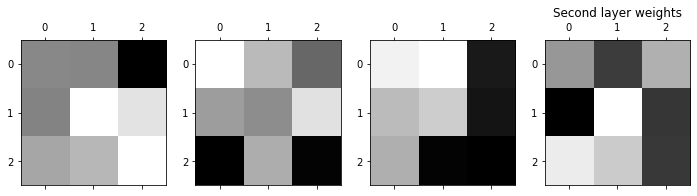

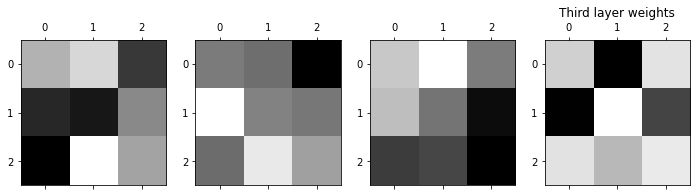

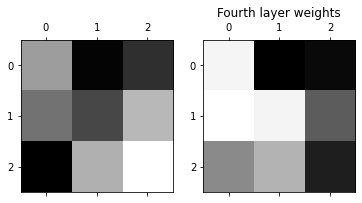

In [41]:
n = first_layer_activation.shape[3] 
print(n)


#plt.gray()

g = plt.figure(figsize=(6,3))
for i in range(2):
    ax = g.add_subplot(1, 2, i + 1)
    ax.matshow(ZERO[i, 0, :, :])
plt.title("First layer weights") 
plt.show()

f = plt.figure(figsize=(12,3))
for i in range(2):
    ax = f.add_subplot(1, 4, i + 1)
    ax.matshow(ONE[i, 0, :, :])  
    ax = f.add_subplot(1, 4, i + 3)
    ax.matshow(ONE[i, 1, :, :])  
plt.title("Second layer weights")
plt.show()

f = plt.figure(figsize=(12,3))
for i in range(2):
    ax = f.add_subplot(1, 4, i +  1)
    ax.matshow(TWO[i, 0, :, :])  
    ax = f.add_subplot(1, 4, i + 3)
    ax.matshow(TWO[i, 1, :, :])  
plt.title("Third layer weights") 
plt.show()

h = plt.figure(figsize=(6,3))
for i in range(2):
    ax = h.add_subplot(1, 2, i + 1)
    ax.matshow(THREE[i, 0, :, :], cmap=plt.cm.Greys_r)
plt.title("Fourth layer weights") 
plt.show()    
    

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.transform import iradon
from skimage.util import random_noise
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

a = np.random.randint(20,30,2)
print(a)

[29 25]
